None

In [ ]:
# setup

import os, json, math, random, glob, time
from pathlib import Path

import numpy as np
import imageio.v2 as imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


DATA_DIR = Path(r"C:\Users\Ayan\Downloads\lego")  

# Helper: load JSON
def jload(p):
    with open(p, "r") as f:
        return json.load(f)

# load dataset (synthetic)
def load_synthetic_split(split="train", half_res=False):
    meta = jload(DATA_DIR / f"transforms_{split}.json")
    imgs, poses = [], []
    for frame in meta["frames"]:
        img_path = DATA_DIR / frame["file_path"]
        if not img_path.suffix:
            img_path = img_path.with_suffix(".png")
        img = imageio.imread(img_path)
        if img.dtype == np.uint16: img = (img / 65535.0).astype(np.float32)
        else: img = (img / 255.0).astype(np.float32)
        if half_res:
            img = img[::2, ::2]
        imgs.append(img)
        poses.append(np.array(frame["transform_matrix"], dtype=np.float32))
    imgs = np.stack(imgs, 0)  # [N, H, W, 4 or 3]
    if imgs.shape[-1] == 4: imgs = imgs[..., :3]  # drop alpha
    poses = np.stack(poses, 0)  # [N, 4, 4]
    H, W = imgs.shape[1:3]
    camera_angle_x = meta["camera_angle_x"]
    focal = .5 * W / np.tan(.5 * camera_angle_x)
    return imgs, poses, H, W, focal

imgs_train, poses_train, H, W, focal = load_synthetic_split("train", half_res=True)  # half-res to fit VRAM
imgs_val, poses_val, *_ = load_synthetic_split("val",   half_res=True)
print(imgs_train.shape, poses_train.shape, H, W, focal)

# rays + encoding 
def get_rays(H, W, focal, c2w):
    i, j = torch.meshgrid(
        torch.arange(W, device=device), torch.arange(H, device=device), indexing='xy'
    )
    dirs = torch.stack([(i - W*0.5)/focal, -(j - H*0.5)/focal, -torch.ones_like(i)], -1)  # OpenGL-ish
    # Rotate and translate
    rays_d = (dirs[..., None, :] * c2w[:3, :3]).sum(-1)
    rays_o = c2w[:3, 3].expand(rays_d.shape)
    return rays_o, rays_d

# Positional encoding
class PosEnc(nn.Module):
    def __init__(self, n_freqs=10, include_input=True, log_sampling=True):
        super().__init__()
        self.include_input = include_input
        if log_sampling:
            self.freq_bands = 2.**torch.linspace(0, n_freqs-1, n_freqs)
        else:
            self.freq_bands = torch.linspace(2.**0., 2.**(n_freqs-1), n_freqs)

    def forward(self, x):
        out = [x] if self.include_input else []
        for f in self.freq_bands.to(x.device):
            out += [torch.sin(f * x), torch.cos(f * x)]
        return torch.cat(out, -1)

# model + renderer 
import torch.nn.functional as F
import torch.nn as nn

class NeRF(nn.Module):
    def __init__(self, D=8, W=256, in_ch_xyz=3*2*10+3, in_ch_dir=3*2*4+3, skips=(4,)):
        super().__init__()
        self.skips = set(skips)
        # point MLP with skip(s)
        self.pts_linears = nn.ModuleList()
        self.pts_linears.append(nn.Linear(in_ch_xyz, W))
        for i in range(1, D):
            if i in self.skips:
                self.pts_linears.append(nn.Linear(W + in_ch_xyz, W))
            else:
                self.pts_linears.append(nn.Linear(W, W))
        # heads
        self.sigma_linear   = nn.Linear(W, 1)
        self.feature_linear = nn.Linear(W, W)
        # view-direction branch
        self.dir_linears = nn.ModuleList([nn.Linear(W + in_ch_dir, W // 2)])
        self.rgb_linear  = nn.Linear(W // 2, 3)

    def forward(self, x, d):
        # x: [B, 63] (positional enc of points), d: [B, 27] (enc of view dirs)
        h = x
        for i, layer in enumerate(self.pts_linears):
            if i in self.skips:          # concatenate BEFORE Linear on skip layers
                h = torch.cat([h, x], dim=-1)
            h = F.relu(layer(h))
        sigma = F.softplus(self.sigma_linear(h))  # use softplus for stability
        feat  = self.feature_linear(h)
        # view-dependent color
        h_dir = torch.cat([feat, d], dim=-1)
        for layer in self.dir_linears:
            h_dir = F.relu(layer(h_dir))
        rgb = torch.sigmoid(self.rgb_linear(h_dir))
        return rgb, sigma

# Positional encoders 
pe_xyz = PosEnc(n_freqs=10).to(device)
pe_dir = PosEnc(n_freqs=4).to(device)

# Model
model  = NeRF().to(device)

# renderer with white background
def render_rays(model, rays_o, rays_d, near=2.0, far=6.0, n_samples=64, perturb=True, white_bkgd=True):
    # stratified samples in [near, far]
    t_vals = torch.linspace(0., 1., steps=n_samples, device=rays_o.device)
    z_vals = near * (1. - t_vals) + far * t_vals                      # [S]
    z_vals = z_vals[None, :].repeat(rays_o.shape[0], 1)               # [N_rays, S]
    if perturb:
        mids = 0.5 * (z_vals[:, :-1] + z_vals[:, 1:])
        upper = torch.cat([mids, z_vals[:, -1:]], -1)
        lower = torch.cat([z_vals[:, :1], mids], -1)
        z_vals = lower + (upper - lower) * torch.rand_like(z_vals)

    # points
    pts = rays_o[:, None, :] + rays_d[:, None, :] * z_vals[..., None] # [N, S, 3]

    # encodings
    dirs = F.normalize(rays_d, dim=-1)
    dirs_enc = pe_dir(dirs)                                           # [N, D_dir]
    pts_enc  = pe_xyz(pts)                                            # [N, S, D_xyz]

    # MLP (flatten samples)
    N, S = pts_enc.shape[:2]
    x = pts_enc.reshape(N*S, -1)
    d = dirs_enc[:, None, :].expand(N, S, -1).reshape(N*S, -1)

    rgb, sigma = model(x, d)                                          # [N*S,3], [N*S,1]
    rgb   = rgb.view(N, S, 3)
    sigma = F.softplus(sigma.view(N, S))                              # softplus is stabler than ReLU

    # volume render
    deltas = z_vals[:, 1:] - z_vals[:, :-1]
    deltas = torch.cat([deltas, 1e10 * torch.ones_like(deltas[:, :1])], -1)
    alpha = 1. - torch.exp(-sigma * deltas)                           # [N,S]
    T = torch.cumprod(torch.cat([torch.ones((N,1), device=alpha.device), 1. - alpha + 1e-10], -1), -1)[:, :-1]
    weights = alpha * T                                               # [N,S]

    rgb_map   = (weights[..., None] * rgb).sum(dim=1)                 # [N,3]
    depth_map = (weights * z_vals).sum(dim=1)                         # [N]

    if white_bkgd:
        acc_map = weights.sum(dim=1, keepdim=True)                    # [N,1]
        rgb_map = rgb_map + (1. - acc_map)                            # composite on white

    return rgb_map.clamp(0,1), depth_map

# train 
def to_tensor(x): return torch.from_numpy(x).to(device)

images = to_tensor(imgs_train)  # [N, H, W, 3]
poses  = to_tensor(poses_train) # [N, 4, 4]

N_imgs, Ht, Wt = images.shape[:3]

psnr_history = []
loss_history = []

iters = 50000  # increase for better result 
batch_rays = 1024
lr = 5e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

psnr_history = []
loss_history = []
best_psnr = 0.0
best_iter = 0

val_psnr_history = []
val_iterations = []
best_val_psnr = 0.0
best_val_iter = 0

def psnr(mse): return -10.0 * torch.log10(mse)

pbar = tqdm(range(iters))
for it in pbar:
    # pick a random image + rays
    i = torch.randint(0, N_imgs, (1,)).item()
    c2w = poses[i]
    rays_o, rays_d = get_rays(Ht, Wt, focal, c2w)
    target = images[i].view(-1, 3)

    # random subset of rays
    idx = torch.randint(0, target.shape[0], (batch_rays,), device=device)
    rays_o_b, rays_d_b = rays_o.view(-1,3)[idx], rays_d.view(-1,3)[idx]
    target_b = target[idx]

    rgb, _ = render_rays(model, rays_o_b, rays_d_b)
    loss = F.mse_loss(rgb, target_b)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Store metrics every iteration 
    current_psnr = psnr(loss).item()
    psnr_history.append(current_psnr)
    loss_history.append(loss.item())

    # Track best PSNR 
    if current_psnr > best_psnr:
        best_psnr = current_psnr
        best_iter = it + 1
        savedir = r"C:\Users\Ayan\Desktop\project\final\none"
        os.makedirs(savedir, exist_ok=True)
        torch.save(model.state_dict(), os.path.join(savedir, "model_best.pth"))

    # Print every 100 iterations 
    if (it + 1) % 100 == 0:
        print(f"it {it+1:5d} | RGB Loss {loss.item():.5f} | "
              f"Total Loss {loss.item():.5f} | PSNR {current_psnr:.2f} dB | "
              f"Best {best_psnr:.2f} dB @ iter {best_iter}")

        # Validation every 1000 iterations 
        if (it + 1) % 1000 == 0:
            model.eval()
            with torch.no_grad():
                val_psnrs = []
                for val_idx in range(min(5, len(imgs_val))):
                    c2w_val = to_tensor(poses_val[val_idx]).float()
                    rays_o_val, rays_d_val = get_rays(Ht, Wt, focal, c2w_val)
                    target_val = to_tensor(imgs_val[val_idx]).float().view(-1, 3)

                    chunk = 4096
                    rgb_chunks = []
                    for j in range(0, rays_o_val.view(-1, 3).shape[0], chunk):
                        rgb_chunk, _ = render_rays(
                            model,
                            rays_o_val.view(-1, 3)[j:j+chunk],
                            rays_d_val.view(-1, 3)[j:j+chunk],
                            near=2.0, far=6.0, n_samples=64,
                            perturb=False, white_bkgd=True
                        )
                        rgb_chunks.append(rgb_chunk)

                    rgb_val = torch.cat(rgb_chunks, 0)
                    val_mse = F.mse_loss(rgb_val, target_val)
                    val_psnrs.append(psnr(val_mse).item())

                avg_val_psnr = np.mean(val_psnrs)

                #  Store validation PSNR 
                val_psnr_history.append(avg_val_psnr)
                val_iterations.append(it + 1)

                # Track best validation PSNR 
                if avg_val_psnr > best_val_psnr:
                    best_val_psnr = avg_val_psnr
                    best_val_iter = it + 1
                    savedir = r"C:\Users\Ayan\Desktop\project\final\none"
                    os.makedirs(savedir, exist_ok=True)
                    torch.save(model.state_dict(), os.path.join(savedir, "model_best_val.pth"))

                # Print with best validation PSNR
                print(f"       → Validation PSNR: {avg_val_psnr:.2f} dB | "
                      f"Best Val: {best_val_psnr:.2f} dB @ iter {best_val_iter}")
            model.train()


print(f"\n{'='*60}")
print(f"Training finished!")
print(f"Best Training PSNR: {best_psnr:.2f} dB @ iteration {best_iter}")
print(f"Best Validation PSNR: {best_val_psnr:.2f} dB @ iteration {best_val_iter}")
print(f"{'='*60}\n")

savedir = r"C:\Users\Ayan\Desktop\project\final\none"
os.makedirs(savedir, exist_ok=True)

# Save training histories 
np.save(os.path.join(savedir, "psnr_history.npy"), np.array(psnr_history))
np.save(os.path.join(savedir, "loss_history.npy"), np.array(loss_history))

#   Save validation histories
np.save(os.path.join(savedir, "val_psnr_history.npy"), np.array(val_psnr_history))
np.save(os.path.join(savedir, "val_iterations.npy"), np.array(val_iterations))

# Save models
torch.save(model.state_dict(), os.path.join(savedir, "model_final.pth"))

# Save best PSNR info (both training and validation)
with open(os.path.join(savedir, "best_psnr.txt"), "w") as f:
    f.write(f"Best Training PSNR: {best_psnr:.2f} dB\n")
    f.write(f"Best Training Iteration: {best_iter}\n")
    f.write(f"\n")
    f.write(f"Best Validation PSNR: {best_val_psnr:.2f} dB\n")
    f.write(f"Best Validation Iteration: {best_val_iter}\n")

print(f"Saved to {savedir}")
print(f"  - model_best.pth (best training PSNR)")
print(f"  - model_best_val.pth (best validation PSNR)")
print(f"  - model_final.pth (final iteration)")

Using device: cuda
(100, 400, 400, 3) (100, 4, 4) 400 400 555.5555155968841


  0%|          | 0/50000 [00:00<?, ?it/s]

it   100 | RGB Loss 0.04223 | Total Loss 0.04223 | PSNR 13.74 dB | Best 16.86 dB @ iter 87
it   200 | RGB Loss 0.03741 | Total Loss 0.03741 | PSNR 14.27 dB | Best 18.17 dB @ iter 166
it   300 | RGB Loss 0.05101 | Total Loss 0.05101 | PSNR 12.92 dB | Best 18.80 dB @ iter 262
it   400 | RGB Loss 0.02712 | Total Loss 0.02712 | PSNR 15.67 dB | Best 18.83 dB @ iter 360
it   500 | RGB Loss 0.02002 | Total Loss 0.02002 | PSNR 16.99 dB | Best 20.88 dB @ iter 405
it   600 | RGB Loss 0.03111 | Total Loss 0.03111 | PSNR 15.07 dB | Best 20.88 dB @ iter 405
it   700 | RGB Loss 0.03542 | Total Loss 0.03542 | PSNR 14.51 dB | Best 20.88 dB @ iter 405
it   800 | RGB Loss 0.01111 | Total Loss 0.01111 | PSNR 19.54 dB | Best 21.41 dB @ iter 761
it   900 | RGB Loss 0.02750 | Total Loss 0.02750 | PSNR 15.61 dB | Best 21.45 dB @ iter 835
it  1000 | RGB Loss 0.00926 | Total Loss 0.00926 | PSNR 20.33 dB | Best 21.52 dB @ iter 964
       → Validation PSNR: 16.55 dB | Best Val: 16.55 dB @ iter 1000
it  1100 | RG

In [ ]:
# render
import os, numpy as np, imageio, time
from tqdm.auto import tqdm

# Load the best model
savedir = r"C:\Users\Ayan\Desktop\project\final\none"  # Same path as training
best_model_path = os.path.join(savedir, "model_best.pth")

# Check if best model exists, otherwise use final model
if os.path.exists(best_model_path):
    print(f"Loading best model from: {best_model_path}")
    model.load_state_dict(torch.load(best_model_path))
    print(" Best model loaded successfully!")
else:
    print(f"  Best model not found, using currently trained model")

model.eval()  # Set to evaluation mode

# use test poses if present, otherwise train poses
json_path = DATA_DIR / "transforms_test.json"
if not json_path.exists():
    json_path = DATA_DIR / "transforms_train.json"
meta = jload(json_path)

# Update paths
output_dir = r"C:\Users\Ayan\Desktop\project\final\none"
os.makedirs(output_dir, exist_ok=True)

gif_path = os.path.join(output_dir, "none.gif")
mp4_path = os.path.join(output_dir, "none.mp4")

@torch.no_grad()
def render_image(model, c2w, H, W, focal, chunk=1024):
    model.eval()
    rays_o, rays_d = get_rays(H, W, focal, to_tensor(np.array(c2w, dtype=np.float32)))
    rays_o = rays_o.view(-1,3); rays_d = rays_d.view(-1,3)
    outs = []
    for i in range(0, rays_o.shape[0], chunk):
        rgb, _ = render_rays(model, rays_o[i:i+chunk], rays_d[i:i+chunk],
                             near=2.0, far=6.0, n_samples=128, perturb=False)
        outs.append(rgb)
    img = torch.cat(outs, 0).view(H, W, 3).cpu().numpy()
    return (img * 255).astype("uint8")

gif_writer = imageio.get_writer(gif_path, mode="I", duration=0.04, loop=0)
mp4_writer = imageio.get_writer(mp4_path, fps=25)

frames = meta["frames"]  # you can sub-sample with frames[::2] for faster/shorter videos
pbar = tqdm(total=len(frames), desc="Rendering frames", unit="frame")

for k, fr in enumerate(frames):
    t0 = time.time()
    img = render_image(model, fr["transform_matrix"], H, W, focal)
    gif_writer.append_data(img)
    mp4_writer.append_data(img)
    dt_ms = int((time.time() - t0) * 1000)
    pbar.set_postfix_str(f"{k+1}/{len(frames)} | {dt_ms} ms")
    pbar.update(1)

pbar.close()
gif_writer.close()
mp4_writer.close()
print("Saved:", gif_path)
print("Saved:", mp4_path)


Loading best model from: C:\Users\Ayan\Desktop\project\final\none\model_best.pth
 Best model loaded successfully!


C:\Users\Ayan\AppData\Local\Temp\ipykernel_20588\3315747911.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


Rendering frames:   0%|          | 0/200 [00:00<?, ?frame/s]

Saved: C:\Users\Ayan\Desktop\project\final\none\none.gif
Saved: C:\Users\Ayan\Desktop\project\final\none\none.mp4


soft

In [ ]:
# setup
import os, json, math, random, glob, time
from pathlib import Path

import numpy as np
import imageio.v2 as imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


# For Colab, after unzipping /content/nerf_synthetic.zip:
# e.g. it contains nerf_synthetic/lego, nerf_synthetic/hotdog, etc.
DATA_DIR = Path(r"C:\Users\Ayan\Downloads\lego")  # change 'lego' to another scene if needed

# Helper: load JSON
def jload(p):
    with open(p, "r") as f:
        return json.load(f)

# Updated synthetic dataset loader with external .npy depth support
from pathlib import Path
import numpy as np
import imageio.v2 as imageio
import json

# Utility 
def jload(path):
    with open(path, 'r') as f:
        return json.load(f)

DATA_DIR = Path(r"C:\Users\Ayan\Downloads\lego")
DEPTH_DIR = Path(r"C:\Users\Ayan\Downloads\lego")  # Folder containing lego_depths_*.npy


def load_synthetic_split(split="train", half_res=False):
    meta = jload(DATA_DIR / f"transforms_{split}.json")

    # load depth npy if available
    npy_depth_path = DEPTH_DIR / f"lego_depths_{split}.npy"
    if npy_depth_path.exists():
        print(f"Loading depth supervision from {npy_depth_path}")
        depth_npy = np.load(npy_depth_path)   # shape: (N,H,W)
    else:
        depth_npy = None

    imgs, poses, depths = [], [], []

    for i, frame in enumerate(meta["frames"]):
        # load image
        img_path = DATA_DIR / frame["file_path"]
        if not img_path.suffix:
            img_path = img_path.with_suffix(".png")
        img = imageio.imread(img_path)

        if img.dtype == np.uint16:
            img = (img / 65535.0).astype(np.float32)
        else:
            img = (img / 255.0).astype(np.float32)

        if half_res:
            img = img[::2, ::2]
        imgs.append(img)

        # pose
        poses.append(np.array(frame["transform_matrix"], dtype=np.float32))

        
        if depth_npy is not None:
            d = depth_npy[i]
            if half_res:
                d = d[::2, ::2]
            depths.append(d)
        else:
            depths.append(None)

    imgs = np.stack(imgs, 0)
    if imgs.shape[-1] == 4:
        imgs = imgs[..., :3]

    poses = np.stack(poses, 0)

    # Turn list → array or None
    if any(d is not None for d in depths):
        depths = np.stack(depths, 0)
    else:
        depths = None

    # Camera intrinsics
    H, W = imgs.shape[1:3]
    camera_angle_x = meta["camera_angle_x"]
    focal = 0.5 * W / np.tan(0.5 * camera_angle_x)

    return imgs, poses, depths, H, W, focal



# imgs_train, poses_train, depths_train, H, W, focal = load_synthetic_split("train", half_res=True)

imgs_train, poses_train, depths_train, H, W, focal = load_synthetic_split("train", half_res=True)  # half-res to fit VRAM
imgs_val, poses_val, *_ = load_synthetic_split("val",   half_res=True)
print(imgs_train.shape, poses_train.shape, depths_train.shape, H, W, focal)


# Load Pre-generated Depth Maps
import numpy as np

# Load the depth maps you already generated
depths_train = np.load(r"C:\Users\Ayan\Downloads\lego\lego_depths_train.npy")
print(f"Loaded depth maps shape: {depths_train.shape}")
print(f"Depth range: [{depths_train.min():.2f}, {depths_train.max():.2f}]")

# rays + encoding
def get_rays(H, W, focal, c2w):
    i, j = torch.meshgrid(
        torch.arange(W, device=device), torch.arange(H, device=device), indexing='xy'
    )
    dirs = torch.stack([(i - W*0.5)/focal, -(j - H*0.5)/focal, -torch.ones_like(i)], -1)  # OpenGL-ish
    # Rotate and translate
    rays_d = (dirs[..., None, :] * c2w[:3, :3]).sum(-1)
    rays_o = c2w[:3, 3].expand(rays_d.shape)
    return rays_o, rays_d

# Positional encoding
class PosEnc(nn.Module):
    def __init__(self, n_freqs=10, include_input=True, log_sampling=True):
        super().__init__()
        self.include_input = include_input
        if log_sampling:
            self.freq_bands = 2.**torch.linspace(0, n_freqs-1, n_freqs)
        else:
            self.freq_bands = torch.linspace(2.**0., 2.**(n_freqs-1), n_freqs)

    def forward(self, x):
        out = [x] if self.include_input else []
        for f in self.freq_bands.to(x.device):
            out += [torch.sin(f * x), torch.cos(f * x)]
        return torch.cat(out, -1)

# model + renderer
import torch.nn.functional as F
import torch.nn as nn

class NeRF(nn.Module):
    def __init__(self, D=8, W=256, in_ch_xyz=3*2*10+3, in_ch_dir=3*2*4+3, skips=(4,)):
        super().__init__()
        self.skips = set(skips)
        # point MLP with skip(s)
        self.pts_linears = nn.ModuleList()
        self.pts_linears.append(nn.Linear(in_ch_xyz, W))
        for i in range(1, D):
            if i in self.skips:
                self.pts_linears.append(nn.Linear(W + in_ch_xyz, W))
            else:
                self.pts_linears.append(nn.Linear(W, W))
        # heads
        self.sigma_linear   = nn.Linear(W, 1)
        self.feature_linear = nn.Linear(W, W)
        # view-direction branch
        self.dir_linears = nn.ModuleList([nn.Linear(W + in_ch_dir, W // 2)])
        self.rgb_linear  = nn.Linear(W // 2, 3)

    def forward(self, x, d):
        # x: [B, 63] (positional enc of points), d: [B, 27] (enc of view dirs)
        h = x
        for i, layer in enumerate(self.pts_linears):
            if i in self.skips:          # concatenate BEFORE Linear on skip layers
                h = torch.cat([h, x], dim=-1)
            h = F.relu(layer(h))
        sigma = F.softplus(self.sigma_linear(h))  # use softplus for stability
        feat  = self.feature_linear(h)
        # view-dependent color
        h_dir = torch.cat([feat, d], dim=-1)
        for layer in self.dir_linears:
            h_dir = F.relu(layer(h_dir))
        rgb = torch.sigmoid(self.rgb_linear(h_dir))
        return rgb, sigma

# Positional encoders from your Cell 3
pe_xyz = PosEnc(n_freqs=10).to(device)
pe_dir = PosEnc(n_freqs=4).to(device)

# Model
model  = NeRF().to(device)

# White-background renderer (used by training & rendering)
def render_rays(model, rays_o, rays_d, near=2.0, far=6.0, n_samples=64, perturb=True, white_bkgd=True):
    # stratified samples in [near, far]
    t_vals = torch.linspace(0., 1., steps=n_samples, device=rays_o.device)
    z_vals = near * (1. - t_vals) + far * t_vals
    z_vals = z_vals[None, :].repeat(rays_o.shape[0], 1)
    if perturb:
        mids = 0.5 * (z_vals[:, :-1] + z_vals[:, 1:])
        upper = torch.cat([mids, z_vals[:, -1:]], -1)
        lower = torch.cat([z_vals[:, :1], mids], -1)
        z_vals = lower + (upper - lower) * torch.rand_like(z_vals)

    # points along rays
    pts = rays_o[:, None, :] + rays_d[:, None, :] * z_vals[..., None]  # [N, S, 3]

    # encodings
    dirs = F.normalize(rays_d, dim=-1)
    dirs_enc = pe_dir(dirs)                 # [N, 27]
    pts_enc  = pe_xyz(pts)                  # [N, S, 63]

    # flatten and run MLP
    N, S = pts_enc.shape[:2]
    x = pts_enc.reshape(N*S, -1)
    d = dirs_enc[:, None, :].expand(N, S, -1).reshape(N*S, -1)
    rgb, sigma = model(x, d)                # [N*S,3], [N*S,1]
    rgb   = rgb.view(N, S, 3)
    sigma = sigma.view(N, S)

    # volume rendering
    deltas = z_vals[:, 1:] - z_vals[:, :-1]
    deltas = torch.cat([deltas, 1e10 * torch.ones_like(deltas[:, :1])], -1)
    alpha = 1. - torch.exp(-sigma * deltas)             # [N, S]
    T = torch.cumprod(torch.cat([torch.ones((N,1), device=alpha.device), 1. - alpha + 1e-10], -1), -1)[:, :-1]
    weights = alpha * T
    rgb_map   = (weights[..., None] * rgb).sum(dim=1)    # [N, 3]
    depth_map = (weights * z_vals).sum(dim=1)            # [N]

    if white_bkgd:
        acc_map = weights.sum(dim=1, keepdim=True)       # [N, 1]
        rgb_map = rgb_map + (1. - acc_map)               # composite on white BG

    return rgb_map.clamp(0, 1), depth_map

#soft
def render_rays_soft(nerf, rays_o, rays_d, near, far, N_samples, white_bg=True):
    # stratified sampling
    z_vals = torch.linspace(near, far, N_samples, device=rays_o.device)
    z_vals = z_vals.unsqueeze(0)  # [1, N_samples]

    pts = rays_o[..., None, :] + rays_d[..., None, :] * z_vals[..., :, None]  # [N_rays, N_samples, 3]
    pts_flat = pts.reshape(-1, 3)
    dirs_flat = rays_d.unsqueeze(1).expand_as(pts).reshape(-1, 3)

    # Encode
    pts_enc  = pe_xyz(pts_flat)
    dirs_enc = pe_dir(dirs_flat)

    # MLP forward
    rgb, sigma = nerf(pts_enc, dirs_enc)
    rgb   = rgb.view(*pts.shape[:-1], 3)   # [N_rays, N_samples, 3]
    sigma = sigma.view(*pts.shape[:-1])    # [N_rays, N_samples]

    # Volume rendering
    deltas = z_vals[..., 1:] - z_vals[..., :-1]
    deltas = torch.cat([deltas, 1e-3 * torch.ones_like(deltas[..., :1])], dim=-1)
    alpha = 1.0 - torch.exp(-sigma * deltas)
    trans = torch.cumprod(torch.cat([torch.ones_like(alpha[..., :1]), 1.-alpha + 1e-10], dim=-1), dim=-1)[..., :-1]
    weights = alpha * trans

    rgb_map = (weights[..., None] * rgb).sum(dim=-2)
    if white_bg:
        rgb_map = rgb_map + (1 - weights.sum(dim=-1, keepdim=True))

    depth_soft = (weights * z_vals).sum(dim=-1)

    return rgb_map, depth_soft


# soft train
def to_tensor(x):
    # Handle None input gracefully
    if x is None:
        return None
    return torch.from_numpy(x).to(device)

# Load images + poses
images = to_tensor(imgs_train).float()        # [N, H, W, 3]
poses  = to_tensor(poses_train).float()       # [N, 4, 4]

psnr_history = []
loss_history = []

# Load depth GT
# Check if depths_train is not None before converting to tensor
depths = to_tensor(depths_train).float() if depths_train is not None else None      # [N, H, W]

N_imgs, Ht, Wt = images.shape[:3]
iters = 50000
batch_rays = 1024
lr = 5e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

psnr_history = []
loss_history = []
best_psnr = 0.0
best_iter = 0

val_psnr_history = []
val_iterations = []
best_val_psnr = 0.0
best_val_iter = 0

def psnr(mse): return -10.0 * torch.log10(mse)

pbar = tqdm(range(iters))
for it in pbar:
    # pick a random image + rays
    i = torch.randint(0, N_imgs, (1,)).item()
    c2w = poses[i]
    rays_o, rays_d = get_rays(Ht, Wt, focal, c2w)
    target = images[i].view(-1, 3)

    # random rays
    idx = torch.randint(0, target.shape[0], (batch_rays,), device=device)
    rays_o_b = rays_o.view(-1,3)[idx]
    rays_d_b = rays_d.view(-1,3)[idx]
    target_b = target[idx]

    # Soft Depth Strategy
    rgb, depth_pred = render_rays_soft(model, rays_o_b, rays_d_b, near=2.0, far=6.0, N_samples=64)

    # RGB loss
    rgb_loss = F.mse_loss(rgb, target_b)
    depth_loss = torch.tensor(0.0, device=device) # Initialize depth_loss to 0

    # Only compute depth loss if depth data is available
    if depths is not None:
        # Depth ground truth for these rays
        depth_gt_full = depths[i]                     # [H, W]
        depth_gt_b = depth_gt_full.view(-1)[idx]      # [batch_rays]

        # Soft depth loss
        depth_loss = ((depth_pred - depth_gt_b)**2).mean()

    # Combined loss
    lambda_depth = 0.01 if depths is not None else 0.0 # Set lambda_depth to 0 if no depth data
    loss = rgb_loss + lambda_depth * depth_loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print RGB, Depth, Total Loss + PSNR
    # Store metrics every iteration
    current_psnr = psnr(rgb_loss).item()
    psnr_history.append(current_psnr)
    loss_history.append(loss.item())

    # Track best PSNR
    if current_psnr > best_psnr:
        best_psnr = current_psnr
        best_iter = it + 1
        save_dir = r"C:\Users\Ayan\Desktop\project\final\soft"
        os.makedirs(save_dir, exist_ok=True)
        torch.save(model.state_dict(), os.path.join(save_dir, "model_best.pth"))

    # Print every 100 iterations
    if (it+1) % 100 == 0:
        if depths is not None:
            print(f"it {it+1:5d} | RGB Loss: {rgb_loss.item():.5f} | "
                  f"Depth Loss: {depth_loss.item():.5f} | "
                  f"Total Loss: {loss.item():.5f} | "
                  f"PSNR: {current_psnr:.2f} dB | "
                  f"Best {best_psnr:.2f} dB @ iter {best_iter}")
        else:
            print(f"it {it+1:5d} | RGB Loss: {rgb_loss.item():.5f} | "
                  f"Total Loss: {loss.item():.5f} | "
                  f"PSNR: {current_psnr:.2f} dB | "
                  f"Best {best_psnr:.2f} dB @ iter {best_iter} (No depth supervision)")

        # Validation every 1000 iterations
        if (it + 1) % 1000 == 0:
            model.eval()
            with torch.no_grad():
                val_psnrs = []
                for val_idx in range(min(5, len(imgs_val))):
                    c2w_val = to_tensor(poses_val[val_idx]).float()
                    rays_o_val, rays_d_val = get_rays(Ht, Wt, focal, c2w_val)
                    target_val = to_tensor(imgs_val[val_idx]).float().view(-1, 3)

                    chunk = 4096
                    rgb_chunks = []
                    for j in range(0, rays_o_val.view(-1, 3).shape[0], chunk):
                        rgb_chunk, _ = render_rays_soft(
                            model,
                            rays_o_val.view(-1, 3)[j:j+chunk],
                            rays_d_val.view(-1, 3)[j:j+chunk],
                            near=2.0, far=6.0, N_samples=64
                        )
                        rgb_chunks.append(rgb_chunk)

                    rgb_val = torch.cat(rgb_chunks, 0)
                    val_mse = F.mse_loss(rgb_val, target_val)
                    val_psnrs.append(psnr(val_mse).item())

                avg_val_psnr = np.mean(val_psnrs)

                # Store validation PSNR
                val_psnr_history.append(avg_val_psnr)
                val_iterations.append(it + 1)

                # Track best validation PSNR
                if avg_val_psnr > best_val_psnr:
                    best_val_psnr = avg_val_psnr
                    best_val_iter = it + 1
                    save_dir = r"C:\Users\Ayan\Desktop\project\final\soft"
                    os.makedirs(save_dir, exist_ok=True)
                    torch.save(model.state_dict(), os.path.join(save_dir, "model_best_val.pth"))

                # Print with best validation PSNR
                print(f"       → Validation PSNR: {avg_val_psnr:.2f} dB | "
                      f"Best Val: {best_val_psnr:.2f} dB @ iter {best_val_iter}")
            model.train()

# Save final results
print(f"\n{'='*60}")
print(f"Training finished!")
print(f"Best Training PSNR: {best_psnr:.2f} dB @ iteration {best_iter}")
print(f"Best Validation PSNR: {best_val_psnr:.2f} dB @ iteration {best_val_iter}")
print(f"{'='*60}\n")

save_dir = r"C:\Users\Ayan\Desktop\project\final\soft"
os.makedirs(save_dir, exist_ok=True)

# Save training histories
np.save(os.path.join(save_dir, "psnr_history.npy"), np.array(psnr_history))
np.save(os.path.join(save_dir, "loss_history.npy"), np.array(loss_history))

#   Save validation histories
np.save(os.path.join(save_dir, "val_psnr_history.npy"), np.array(val_psnr_history))
np.save(os.path.join(save_dir, "val_iterations.npy"), np.array(val_iterations))

# Save models
torch.save(model.state_dict(), os.path.join(save_dir, "model_final.pth"))

# Save best PSNR info (both training and validation)
with open(os.path.join(save_dir, "best_psnr.txt"), "w") as f:
    f.write(f"Best Training PSNR: {best_psnr:.2f} dB\n")
    f.write(f"Best Training Iteration: {best_iter}\n")
    f.write(f"\n")
    f.write(f"Best Validation PSNR: {best_val_psnr:.2f} dB\n")
    f.write(f"Best Validation Iteration: {best_val_iter}\n")

print(f"Saved to {save_dir}")
print(f"  - model_best.pth (best training PSNR)")
print(f"  - model_best_val.pth (best validation PSNR)")
print(f"  - model_final.pth (final iteration)")


Using device: cuda
Loading depth supervision from C:\Users\Ayan\Downloads\lego\lego_depths_train.npy
Loading depth supervision from C:\Users\Ayan\Downloads\lego\lego_depths_val.npy
(100, 400, 400, 3) (100, 4, 4) (100, 200, 200) 400 400 555.5555155968841
Loaded depth maps shape: (100, 400, 400)
Depth range: [2.00, 6.00]


  0%|          | 0/50000 [00:00<?, ?it/s]

it   100 | RGB Loss: 0.05615 | Depth Loss: 1.99532 | Total Loss: 0.07610 | PSNR: 12.51 dB | Best 16.01 dB @ iter 45
it   200 | RGB Loss: 0.05821 | Depth Loss: 0.72107 | Total Loss: 0.06542 | PSNR: 12.35 dB | Best 17.31 dB @ iter 159
it   300 | RGB Loss: 0.02580 | Depth Loss: 0.97820 | Total Loss: 0.03558 | PSNR: 15.88 dB | Best 18.18 dB @ iter 292
it   400 | RGB Loss: 0.01198 | Depth Loss: 1.65646 | Total Loss: 0.02855 | PSNR: 19.22 dB | Best 19.22 dB @ iter 400
it   500 | RGB Loss: 0.02288 | Depth Loss: 1.49903 | Total Loss: 0.03787 | PSNR: 16.41 dB | Best 19.32 dB @ iter 456
it   600 | RGB Loss: 0.02161 | Depth Loss: 1.08703 | Total Loss: 0.03248 | PSNR: 16.65 dB | Best 19.39 dB @ iter 531
it   700 | RGB Loss: 0.02044 | Depth Loss: 1.04865 | Total Loss: 0.03092 | PSNR: 16.90 dB | Best 20.11 dB @ iter 615
it   800 | RGB Loss: 0.01765 | Depth Loss: 1.01177 | Total Loss: 0.02777 | PSNR: 17.53 dB | Best 20.95 dB @ iter 750
it   900 | RGB Loss: 0.01796 | Depth Loss: 1.27480 | Total Loss: 

In [ ]:
# render GIF/MP4
import os, numpy as np, imageio, time
from tqdm.auto import tqdm

# Load the best model
save_dir = r"C:\Users\Ayan\Desktop\project\final\soft"
best_model_path = os.path.join(save_dir, "model_best.pth")

if os.path.exists(best_model_path):
    print(f"Loading best model from: {best_model_path}")
    model.load_state_dict(torch.load(best_model_path))
    print(" Best model loaded successfully!")
else:
    print(f" Best model not found, using currently trained model")

model.eval()

# use test poses if present, otherwise train poses
json_path = DATA_DIR / "transforms_test.json"
if not json_path.exists():
    json_path = DATA_DIR / "transforms_train.json"
meta = jload(json_path)

gif_path = r"C:\Users\Ayan\Desktop\project\final\soft\soft.gif"
mp4_path = r"C:\Users\Ayan\Desktop\project\final\soft\soft.mp4"

# Extract the directory paths from your file paths
gif_dir = Path(gif_path).parent
mp4_dir = Path(mp4_path).parent

# Create the directories if they do not exist
os.makedirs(gif_dir, exist_ok=True)
os.makedirs(mp4_dir, exist_ok=True)

@torch.no_grad()
def render_image(model, c2w, H, W, focal, chunk=4096):
    model.eval()
    rays_o, rays_d = get_rays(H, W, focal, to_tensor(np.array(c2w, dtype=np.float32)))
    rays_o = rays_o.view(-1,3); rays_d = rays_d.view(-1,3)
    outs = []
    for i in range(0, rays_o.shape[0], chunk):
        rgb, _ = render_rays(model, rays_o[i:i+chunk], rays_d[i:i+chunk],
                             near=2.0, far=6.0, n_samples=128, perturb=False)
        outs.append(rgb)
    img = torch.cat(outs, 0).view(H, W, 3).cpu().numpy()
    return (img * 255).astype("uint8")

# The original code will now work
gif_writer = imageio.get_writer(gif_path, mode="I", duration=0.04, loop=0)
mp4_writer = imageio.get_writer(mp4_path, fps=25)

frames = meta["frames"]  # you can sub-sample with frames[::2] for faster/shorter videos
pbar = tqdm(total=len(frames), desc="Rendering frames", unit="frame")

for k, fr in enumerate(frames):
    t0 = time.time()
    img = render_image(model, fr["transform_matrix"], H, W, focal)
    gif_writer.append_data(img)
    mp4_writer.append_data(img)
    dt_ms = int((time.time() - t0) * 1000)
    pbar.set_postfix_str(f"{k+1}/{len(frames)} | {dt_ms} ms")
    pbar.update(1)

pbar.close()
gif_writer.close()
mp4_writer.close()
print("Saved:", gif_path)
print("Saved:", mp4_path)


Loading best model from: C:\Users\Ayan\Desktop\project\final\soft\model_best.pth
 Best model loaded successfully!


C:\Users\Ayan\AppData\Local\Temp\ipykernel_20588\2055465027.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


Rendering frames:   0%|          | 0/200 [00:00<?, ?frame/s]

Saved: C:\Users\Ayan\Desktop\project\final\soft\soft.gif
Saved: C:\Users\Ayan\Desktop\project\final\soft\soft.mp4


Hard

In [ ]:
# setup
import os, json, math, random, glob, time
from pathlib import Path

import numpy as np
import imageio.v2 as imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

DATA_DIR = Path(r"C:\Users\Ayan\Downloads\lego")  # change 'lego' to another scene if needed

# Helper: load JSON
def jload(p):
    with open(p, "r") as f:
        return json.load(f)

# Updated synthetic dataset loader with external .npy depth support
from pathlib import Path
import numpy as np
import imageio.v2 as imageio
import json

# Utility 
def jload(path):
    with open(path, 'r') as f:
        return json.load(f)

DATA_DIR = Path(r"C:\Users\Ayan\Downloads\lego")
DEPTH_DIR = Path(r"C:\Users\Ayan\Downloads\lego")  # Folder containing lego_depths_*.npy


def load_synthetic_split(split="train", half_res=False):
    meta = jload(DATA_DIR / f"transforms_{split}.json")

    # load depth npy if available
    npy_depth_path = DEPTH_DIR / f"lego_depths_{split}.npy"
    if npy_depth_path.exists():
        print(f"Loading depth supervision from {npy_depth_path}")
        depth_npy = np.load(npy_depth_path)   # shape: (N,H,W)
    else:
        depth_npy = None

    imgs, poses, depths = [], [], []

    for i, frame in enumerate(meta["frames"]):
        # load image
        img_path = DATA_DIR / frame["file_path"]
        if not img_path.suffix:
            img_path = img_path.with_suffix(".png")
        img = imageio.imread(img_path)

        if img.dtype == np.uint16:
            img = (img / 65535.0).astype(np.float32)
        else:
            img = (img / 255.0).astype(np.float32)

        if half_res:
            img = img[::2, ::2]
        imgs.append(img)

        # 
        poses.append(np.array(frame["transform_matrix"], dtype=np.float32))

        
        if depth_npy is not None:
            d = depth_npy[i]
            if half_res:
                d = d[::2, ::2]
            depths.append(d)
        else:
            depths.append(None)

    imgs = np.stack(imgs, 0)
    if imgs.shape[-1] == 4:
        imgs = imgs[..., :3]

    poses = np.stack(poses, 0)

    # Turn list → array or None
    if any(d is not None for d in depths):
        depths = np.stack(depths, 0)
    else:
        depths = None

    # Camera intrinsics
    H, W = imgs.shape[1:3]
    camera_angle_x = meta["camera_angle_x"]
    focal = 0.5 * W / np.tan(0.5 * camera_angle_x)

    return imgs, poses, depths, H, W, focal

imgs_train, poses_train, depths_train, H, W, focal = load_synthetic_split("train", half_res=True)  # half-res to fit VRAM
imgs_val, poses_val, *_ = load_synthetic_split("val",   half_res=True)
print(imgs_train.shape, poses_train.shape, depths_train.shape, H, W, focal)

# Load Pre-generated Depth Maps
import numpy as np

# Load the depth maps you already generated
depths_train = np.load(r"C:\Users\Ayan\Downloads\lego\lego_depths_train.npy")
print(f"Loaded depth maps shape: {depths_train.shape}")
print(f"Depth range: [{depths_train.min():.2f}, {depths_train.max():.2f}]")

# rays + encoding
def get_rays(H, W, focal, c2w):
    i, j = torch.meshgrid(
        torch.arange(W, device=device), torch.arange(H, device=device), indexing='xy'
    )
    dirs = torch.stack([(i - W*0.5)/focal, -(j - H*0.5)/focal, -torch.ones_like(i)], -1)  # OpenGL-ish
    # Rotate and translate
    rays_d = (dirs[..., None, :] * c2w[:3, :3]).sum(-1)
    rays_o = c2w[:3, 3].expand(rays_d.shape)
    return rays_o, rays_d

# Positional encoding
class PosEnc(nn.Module):
    def __init__(self, n_freqs=10, include_input=True, log_sampling=True):
        super().__init__()
        self.include_input = include_input
        if log_sampling:
            self.freq_bands = 2.**torch.linspace(0, n_freqs-1, n_freqs)
        else:
            self.freq_bands = torch.linspace(2.**0., 2.**(n_freqs-1), n_freqs)

    def forward(self, x):
        out = [x] if self.include_input else []
        for f in self.freq_bands.to(x.device):
            out += [torch.sin(f * x), torch.cos(f * x)]
        return torch.cat(out, -1)

# model + renderer
import torch.nn.functional as F
import torch.nn as nn

class NeRF(nn.Module):
    def __init__(self, D=8, W=256, in_ch_xyz=3*2*10+3, in_ch_dir=3*2*4+3, skips=(4,)):
        super().__init__()
        self.skips = set(skips)
        # point MLP with skip(s)
        self.pts_linears = nn.ModuleList()
        self.pts_linears.append(nn.Linear(in_ch_xyz, W))
        for i in range(1, D):
            if i in self.skips:
                self.pts_linears.append(nn.Linear(W + in_ch_xyz, W))
            else:
                self.pts_linears.append(nn.Linear(W, W))
        # heads
        self.sigma_linear   = nn.Linear(W, 1)
        self.feature_linear = nn.Linear(W, W)
        # view-direction branch
        self.dir_linears = nn.ModuleList([nn.Linear(W + in_ch_dir, W // 2)])
        self.rgb_linear  = nn.Linear(W // 2, 3)

    def forward(self, x, d):
        # x: [B, 63] (positional enc of points), d: [B, 27] (enc of view dirs)
        h = x
        for i, layer in enumerate(self.pts_linears):
            if i in self.skips:          # concatenate BEFORE Linear on skip layers
                h = torch.cat([h, x], dim=-1)
            h = F.relu(layer(h))
        sigma = F.softplus(self.sigma_linear(h))  # use softplus for stability
        feat  = self.feature_linear(h)
        # view-dependent color
        h_dir = torch.cat([feat, d], dim=-1)
        for layer in self.dir_linears:
            h_dir = F.relu(layer(h_dir))
        rgb = torch.sigmoid(self.rgb_linear(h_dir))
        return rgb, sigma

# Positional encoders from your Cell 3
pe_xyz = PosEnc(n_freqs=10).to(device)
pe_dir = PosEnc(n_freqs=4).to(device)

# Model
model  = NeRF().to(device)

# White-background renderer (used by training & rendering)
def render_rays(model, rays_o, rays_d, near=2.0, far=6.0, n_samples=64, perturb=True, white_bkgd=True):
    # stratified samples in [near, far]
    t_vals = torch.linspace(0., 1., steps=n_samples, device=rays_o.device)
    z_vals = near * (1. - t_vals) + far * t_vals
    z_vals = z_vals[None, :].repeat(rays_o.shape[0], 1)
    if perturb:
        mids = 0.5 * (z_vals[:, :-1] + z_vals[:, 1:])
        upper = torch.cat([mids, z_vals[:, -1:]], -1)
        lower = torch.cat([z_vals[:, :1], mids], -1)
        z_vals = lower + (upper - lower) * torch.rand_like(z_vals)

    # points along rays
    pts = rays_o[:, None, :] + rays_d[:, None, :] * z_vals[..., None]  # [N, S, 3]

    # encodings
    dirs = F.normalize(rays_d, dim=-1)
    dirs_enc = pe_dir(dirs)                 # [N, 27]
    pts_enc  = pe_xyz(pts)                  # [N, S, 63]

    # flatten and run MLP
    N, S = pts_enc.shape[:2]
    x = pts_enc.reshape(N*S, -1)
    d = dirs_enc[:, None, :].expand(N, S, -1).reshape(N*S, -1)
    rgb, sigma = model(x, d)                # [N*S,3], [N*S,1]
    rgb   = rgb.view(N, S, 3)
    sigma = sigma.view(N, S)

    # volume rendering
    deltas = z_vals[:, 1:] - z_vals[:, :-1]
    deltas = torch.cat([deltas, 1e10 * torch.ones_like(deltas[:, :1])], -1)
    alpha = 1. - torch.exp(-sigma * deltas)             # [N, S]
    T = torch.cumprod(torch.cat([torch.ones((N,1), device=alpha.device), 1. - alpha + 1e-10], -1), -1)[:, :-1]
    weights = alpha * T
    rgb_map   = (weights[..., None] * rgb).sum(dim=1)    # [N, 3]
    depth_map = (weights * z_vals).sum(dim=1)            # [N]

    if white_bkgd:
        acc_map = weights.sum(dim=1, keepdim=True)       # [N, 1]
        rgb_map = rgb_map + (1. - acc_map)               # composite on white BG

    return rgb_map.clamp(0, 1), depth_map

def positional_encoding(x, L=10):
    """
    x: [N, D] coordinates (pts or dirs)
    Returns: [N, D*2*L + D] encoded coordinates
    """
    out = [x]
    for i in range(L):
        for fn in [torch.sin, torch.cos]:
            out.append(fn(2.0**i * x))
    return torch.cat(out, dim=-1)

def run_model(model, pts, dirs):
    """
    pts: [N,3]
    dirs: [N,3]
    Returns: rgb [N,3], sigma [N]
    """
    # Positional encoding
    pts_enc = positional_encoding(pts, L=10)
    dirs_enc = positional_encoding(dirs, L=4)

    # Forward pass
    out = model(pts_enc, dirs_enc)

    # If model returns a tuple
    if isinstance(out, tuple):
        out = out[0]

    rgb = torch.sigmoid(out[..., :3])
    sigma = F.relu(out[..., 3])
    return rgb, sigma


def render_rays_hard(model, rays_o, rays_d, near, far, N_samples,
                     depth_gt=None, depth_mask=None, eps=0.5,
                     white_bg=True, return_extras=False):

    N_rays = rays_o.shape[0]

    if depth_gt is not None:
        z_vals = depth_gt.unsqueeze(1) + torch.linspace(-eps, eps, 32).to(device)
    else:
        z_vals = torch.linspace(near, far, N_samples, device=rays_o.device)
        z_vals = z_vals[None, :].expand(N_rays, -1)


    """
    HARD strategy: 75% samples concentrated near depth surface
    eps: window size in meters (default 0.3m = ±15cm)
    """
    N_rays = rays_o.shape[0]

    # DEPTH-GUIDED SAMPLING (SELF-CONTAINED) 
    if depth_gt is not None and depth_mask is not None and depth_mask.any():
        # HARD strategy: 75% samples near depth, 25% uniform
        N_guided = int(N_samples * 0.75)  # e.g., 48 samples
        N_uniform = N_samples - N_guided   # e.g., 16 samples

        # 1) Uniform samples for exploration
        t_uniform = torch.linspace(near, far, N_uniform, device=rays_o.device)
        t_uniform = t_uniform[None, :].expand(N_rays, -1)  # [N, N_uniform]

        # 2) Depth-guided samples (concentrated near surface)
        t_guided = []

        for i in range(N_rays):
            if depth_mask[i] > 0.5:  # Valid depth
                # ±15cm window around measured depth
                depth_center = depth_gt[i].item()
                depth_min = max(near, depth_center - eps/2)
                depth_max = min(far, depth_center + eps/2)

                # Sample uniformly in window
                t_ray = torch.linspace(depth_min, depth_max, N_guided, device=rays_o.device)
            else:
                # Fallback to uniform if no valid depth
                t_ray = torch.linspace(near, far, N_guided, device=rays_o.device)

            t_guided.append(t_ray)

        t_guided = torch.stack(t_guided, dim=0)  # [N, N_guided]

        # 3) Combine and sort
        z_vals = torch.cat([t_uniform, t_guided], dim=1)  # [N, N_samples]
        z_vals, _ = torch.sort(z_vals, dim=1)
    else:
        # Fallback: uniform sampling
        z_vals = torch.linspace(near, far, N_samples, device=rays_o.device)
        z_vals = z_vals[None, :].expand(N_rays, -1)  # [N, N_samples]

    # VOLUME RENDERING
    # points along rays
    pts = rays_o[:, None, :] + rays_d[:, None, :] * z_vals[..., None]  # [N, S, 3]

    # encode dirs and pts
    dirs = F.normalize(rays_d, dim=-1)  # [N, 3]
    dirs_enc = pe_dir(dirs)  # [N, 27]
    pts_enc = pe_xyz(pts)  # [N, S, 63]

    N, S = pts_enc.shape[:2]
    x = pts_enc.reshape(N * S, -1)  # [N*S, 63]
    d = dirs_enc[:, None, :].expand(N, S, -1).reshape(N * S, -1)  # [N*S, 27]

    rgb, sigma = model(x, d)  # [N*S,3], [N*S,1]
    rgb = rgb.view(N, S, 3)
    sigma = sigma.view(N, S)

    # volume rendering
    deltas = z_vals[:, 1:] - z_vals[:, :-1]
    deltas = torch.cat([deltas, 1e-3 * torch.ones_like(deltas[:, :1])], dim=-1)

    alpha = 1.0 - torch.exp(-sigma * deltas)
    trans = torch.cumprod(
        torch.cat([torch.ones_like(alpha[:, :1]), 1. - alpha + 1e-10], dim=-1),
        dim=-1
    )[:, :-1]

    weights = alpha * trans  # [N, S]

    rgb_map = (weights[..., None] * rgb).sum(dim=1)  # [N, 3]
    if white_bg:
        rgb_map = rgb_map + (1 - weights.sum(dim=1, keepdim=True))

    
    depth_pred = (weights * z_vals).sum(dim=1)  # [N] - differentiable

    if return_extras:
        return rgb_map, depth_pred, weights, z_vals, sigma
    else:
        return rgb_map, depth_pred

def free_space_loss(sigma, z_vals, depth_gt, depth_mask):
    # z_vals: [1, S] or [N, S] → make [N, S]
    if z_vals.shape[0] == 1:
        z_vals = z_vals.expand(sigma.shape[0], -1)

    # samples before GT surface
    before_surface = z_vals < depth_gt.unsqueeze(-1)          # [N, S]
    valid = depth_mask.unsqueeze(-1) > 0.5                    # [N, 1]
    mask = before_surface & valid                             # [N, S]

    if mask.sum() == 0:
        return torch.tensor(0.0, device=sigma.device)

    loss = (sigma * mask.float()).sum() / (mask.float().sum() + 1e-6)
    return loss


def surface_concentration_loss(weights, z_vals, depth_gt, depth_mask, mode='l1'):
    if z_vals.shape[0] == 1:
        z_vals = z_vals.expand(weights.shape[0], -1)

    if mode == 'l1':
        max_idx = torch.argmax(weights, dim=-1)               # [N]
        depth_pred = z_vals[torch.arange(len(max_idx)), max_idx]

        diff = torch.abs(depth_pred - depth_gt)               # [N]
        valid = depth_mask > 0.5
        if valid.sum() == 0:
            return torch.tensor(0.0, device=weights.device)
        loss = (diff * valid.float()).sum() / (valid.float().sum() + 1e-6)
        return loss

    elif mode == 'entropy':
        eps = 1e-8
        entropy = -(weights * torch.log(weights + eps)).sum(dim=-1)
        loss = (entropy * depth_mask.float()).mean()
        return loss

    else:
        raise ValueError(f"Unknown mode: {mode}")

def surface_concentration_loss(weights, z_vals, depth_gt, depth_mask):
    """
    Encourage weights to concentrate at the measured depth.
    We measure mean absolute distance weighted by weights; smaller is better.
    """
    if (depth_gt is None) or (depth_mask is None) or (not depth_mask.any()):
        return torch.tensor(0.0, device=weights.device)

    depth_gt = depth_gt.to(weights.device)
    depth_mask = depth_mask.to(weights.device)

    # Predicted depth per ray (weighted mean)
    depth_pred = (weights * z_vals).sum(dim=1)  # [N]
    # L1 between predicted depth and GT (only where GT exists)
    depth_l1 = (depth_pred[depth_mask] - depth_gt[depth_mask]).abs().mean()

    # Dispersion/variance around the predicted depth (encourage peak)
    depth_sq = (weights * (z_vals ** 2)).sum(dim=1)
    variance = (depth_sq - depth_pred ** 2).clamp(min=0.0)
    variance_loss = variance[depth_mask].mean()

    return depth_l1 + 0.1 * variance_loss

# Hard train
def to_tensor(x):
    # Handle None input gracefully
    if x is None:
        return None
    return torch.from_numpy(x).to(device)

# Load images + poses
images = to_tensor(imgs_train).float()        # [N, H, W, 3]
poses  = to_tensor(poses_train).float()       # [N, 4, 4]

psnr_history = []
loss_history = []

# Load depth GT
# Check if depths_train is not None before converting to tensor
depths = to_tensor(depths_train).float() if depths_train is not None else None      # [N, H, W]

N_imgs, Ht, Wt = images.shape[:3]
iters = 50000
batch_rays = 1024
lr = 5e-4
N_samples = 64  # or 128, depending on your memory budget
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

psnr_history = []
loss_history = []
best_psnr = 0.0
best_iter = 0

val_psnr_history = []
val_iterations = []
best_val_psnr = 0.0
best_val_iter = 0

def psnr(mse): return -10.0 * torch.log10(mse)

pbar = tqdm(range(iters))
for it in pbar:
    # pick a random image + rays
    i = torch.randint(0, N_imgs, (1,)).item()
    c2w = poses[i]
    rays_o, rays_d = get_rays(Ht, Wt, focal, c2w)
    target = images[i].view(-1, 3)

    # random rays
    idx = torch.randint(0, target.shape[0], (batch_rays,), device=device)
    rays_o_b = rays_o.view(-1,3)[idx]
    rays_d_b = rays_d.view(-1,3)[idx]
    target_b = target[idx]

    # ----  Depth Strategy ----
    rgb_pred, depth_pred, weights, z_vals, sigma = render_rays_hard(
        model,
        rays_o_b,
        rays_d_b,
        near=2.0,
        far=6.0,
        N_samples=N_samples,
        depth_gt=depth_gt_b,        # None or tensor
        depth_mask=depth_mask_b,    # None or tensor
        eps=0.5,            # schedule this
        white_bg=True,
        return_extras=True
    )



    # RGB loss
    rgb_loss = F.mse_loss(rgb_pred, target_b)
    depth_loss = torch.tensor(0.0, device=device) # Initialize depth_loss to 0

    # Only compute depth loss if depth data is available
# Prepare depth GT and mask
    if depths is not None:
        depth_gt_full = depths[i]                  # [H, W]
        depth_gt_b = depth_gt_full.view(-1)[idx]   # [batch_rays]

        near, far = 2.0, 6.0

        depth_valid = (depth_gt_full > near) & (depth_gt_full < far)
        depth_mask_b = depth_valid.view(-1)[idx]
    else:
        depth_gt_b = None
        depth_mask_b = None


    if depths is not None:
        free_space = free_space_loss(sigma, z_vals, depth_gt_b, depth_mask_b)
        surface = surface_concentration_loss(weights, z_vals, depth_gt_b, depth_mask_b)

        depth_loss = free_space + surface
        loss = rgb_loss + 0.001 * free_space + 0.001 * surface
    else:
        free_space = torch.tensor(0.0, device=device)
        surface = torch.tensor(0.0, device=device)
        loss = rgb_loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    # Store metrics every iteration
    current_psnr = psnr(rgb_loss).item()
    psnr_history.append(current_psnr)
    loss_history.append(loss.item())

    # Track best PSNR 
    if current_psnr > best_psnr:
        best_psnr = current_psnr
        best_iter = it + 1
        save_dir = r"/content/drive/MyDrive/results/hard"
        os.makedirs(save_dir, exist_ok=True)
        torch.save(model.state_dict(), os.path.join(save_dir, "model_best.pth"))

    # Print every 100 iterations
    if (it+1) % 100 == 0:
        if depths is not None:
            print(f"it {it+1:5d} | RGB Loss: {rgb_loss.item():.5f} | "
                  f"Depth Loss: {depth_loss.item():.5f} | "
                  f"Total Loss: {loss.item():.5f} | "
                  f"PSNR: {current_psnr:.2f} dB | "
                  f"Best {best_psnr:.2f} dB @ iter {best_iter}")
        else:
            print(f"it {it+1:5d} | RGB Loss: {rgb_loss.item():.5f} | "
                  f"Total Loss: {loss.item():.5f} | "
                  f"PSNR: {current_psnr:.2f} dB | "
                  f"Best {best_psnr:.2f} dB @ iter {best_iter} (No depth supervision)")

        # Validation every 1000 iterations
        if (it + 1) % 1000 == 0:
            model.eval()
            with torch.no_grad():
                val_psnrs = []
                for val_idx in range(min(5, len(imgs_val))):
                    c2w_val = to_tensor(poses_val[val_idx]).float()
                    rays_o_val, rays_d_val = get_rays(Ht, Wt, focal, c2w_val)
                    target_val = to_tensor(imgs_val[val_idx]).float().view(-1, 3)

                    chunk = 4096
                    rgb_chunks = []
                    for j in range(0, rays_o_val.view(-1, 3).shape[0], chunk):
                        rgb_chunk, _ = render_rays_hard(
                            model,
                            rays_o_val.view(-1, 3)[j:j+chunk],
                            rays_d_val.view(-1, 3)[j:j+chunk],
                            near=2.0, far=6.0, N_samples=64,
                            depth_gt=None, depth_mask=None,
                            return_extras=False
                        )
                        rgb_chunks.append(rgb_chunk)

                    rgb_val = torch.cat(rgb_chunks, 0)
                    val_mse = F.mse_loss(rgb_val, target_val)
                    val_psnrs.append(psnr(val_mse).item())

                avg_val_psnr = np.mean(val_psnrs)

                # Store validation PSNR
                val_psnr_history.append(avg_val_psnr)
                val_iterations.append(it + 1)

                # Track best validation PSNR
                if avg_val_psnr > best_val_psnr:
                    best_val_psnr = avg_val_psnr
                    best_val_iter = it + 1
                    save_dir = r"C:\Users\Ayan\Desktop\project\final\hard"
                    os.makedirs(save_dir, exist_ok=True)
                    torch.save(model.state_dict(), os.path.join(save_dir, "model_best_val.pth"))

                # Print with best validation PSNR
                print(f"       → Validation PSNR: {avg_val_psnr:.2f} dB | "
                      f"Best Val: {best_val_psnr:.2f} dB @ iter {best_val_iter}")
            model.train()




print("Training finished!")

# Save final results
print(f"\n{'='*60}")
print(f"Training finished!")
print(f"Best Training PSNR: {best_psnr:.2f} dB @ iteration {best_iter}")
print(f"Best Validation PSNR: {best_val_psnr:.2f} dB @ iteration {best_val_iter}")
print(f"{'='*60}\n")

save_dir = r"C:\Users\Ayan\Desktop\project\final\hard"
os.makedirs(save_dir, exist_ok=True)

# Save training histories
np.save(os.path.join(save_dir, "psnr_history.npy"), np.array(psnr_history))
np.save(os.path.join(save_dir, "loss_history.npy"), np.array(loss_history))

#   Save validation histories
np.save(os.path.join(save_dir, "val_psnr_history.npy"), np.array(val_psnr_history))
np.save(os.path.join(save_dir, "val_iterations.npy"), np.array(val_iterations))

# Save models
torch.save(model.state_dict(), os.path.join(save_dir, "model_final.pth"))

# Save best PSNR info (both training and validation)
with open(os.path.join(save_dir, "best_psnr.txt"), "w") as f:
    f.write(f"Best Training PSNR: {best_psnr:.2f} dB\n")
    f.write(f"Best Training Iteration: {best_iter}\n")
    f.write(f"\n")
    f.write(f"Best Validation PSNR: {best_val_psnr:.2f} dB\n")
    f.write(f"Best Validation Iteration: {best_val_iter}\n")

print(f"Saved to {save_dir}")
print(f"  - model_best.pth (best training PSNR)")
print(f"  - model_best_val.pth (best validation PSNR)")
print(f"  - model_final.pth (final iteration)")

Using device: cuda
Loading depth supervision from C:\Users\Ayan\Downloads\lego\lego_depths_train.npy
Loading depth supervision from C:\Users\Ayan\Downloads\lego\lego_depths_val.npy
(100, 400, 400, 3) (100, 4, 4) (100, 200, 200) 400 400 555.5555155968841
Loaded depth maps shape: (100, 400, 400)
Depth range: [2.00, 6.00]


  0%|          | 0/50000 [00:00<?, ?it/s]

it   100 | RGB Loss: 0.07343 | Depth Loss: 1.72300 | Total Loss: 0.07515 | PSNR: 11.34 dB | Best 16.77 dB @ iter 67
it   200 | RGB Loss: 0.03176 | Depth Loss: 1.81863 | Total Loss: 0.03357 | PSNR: 14.98 dB | Best 16.84 dB @ iter 159
it   300 | RGB Loss: 0.03489 | Depth Loss: 2.36303 | Total Loss: 0.03725 | PSNR: 14.57 dB | Best 17.49 dB @ iter 211
it   400 | RGB Loss: 0.02755 | Depth Loss: 1.77194 | Total Loss: 0.02933 | PSNR: 15.60 dB | Best 19.00 dB @ iter 377
it   500 | RGB Loss: 0.02477 | Depth Loss: 2.01815 | Total Loss: 0.02679 | PSNR: 16.06 dB | Best 19.43 dB @ iter 493
it   600 | RGB Loss: 0.02773 | Depth Loss: 1.53028 | Total Loss: 0.02926 | PSNR: 15.57 dB | Best 19.80 dB @ iter 585
it   700 | RGB Loss: 0.02156 | Depth Loss: 2.10327 | Total Loss: 0.02366 | PSNR: 16.66 dB | Best 19.80 dB @ iter 585
it   800 | RGB Loss: 0.02305 | Depth Loss: 2.12808 | Total Loss: 0.02518 | PSNR: 16.37 dB | Best 20.02 dB @ iter 791
it   900 | RGB Loss: 0.02115 | Depth Loss: 2.70460 | Total Loss: 

In [ ]:
# render GIF/MP4
import os, numpy as np, imageio, time
from tqdm.auto import tqdm

# Load the best model
save_dir = r"C:\Users\Ayan\Desktop\project\final\hard"
best_model_path = os.path.join(save_dir, "model_best.pth")

if os.path.exists(best_model_path):
    print(f"Loading best model from: {best_model_path}")
    model.load_state_dict(torch.load(best_model_path))
    print(" Best model loaded successfully!")
else:
    print(f" Best model not found, using currently trained model")

model.eval()

# use test poses if present, otherwise train poses
json_path = DATA_DIR / "transforms_test.json"
if not json_path.exists():
    json_path = DATA_DIR / "transforms_train.json"
meta = jload(json_path)

gif_path = r"C:\Users\Ayan\Desktop\project\final\hard\hard.gif"
mp4_path = r"C:\Users\Ayan\Desktop\project\final\hard\hard.mp4"

# Extract the directory paths from your file paths
gif_dir = Path(gif_path).parent
mp4_dir = Path(mp4_path).parent

# Create the directories if they do not exist
os.makedirs(gif_dir, exist_ok=True)
os.makedirs(mp4_dir, exist_ok=True)

@torch.no_grad()
def render_image(model, c2w, H, W, focal, chunk=4096):
    model.eval()
    rays_o, rays_d = get_rays(H, W, focal, to_tensor(np.array(c2w, dtype=np.float32)))
    rays_o = rays_o.view(-1,3); rays_d = rays_d.view(-1,3)
    outs = []
    for i in range(0, rays_o.shape[0], chunk):
        rgb, _ = render_rays(model, rays_o[i:i+chunk], rays_d[i:i+chunk],
                             near=2.0, far=6.0, n_samples=128, perturb=False)
        outs.append(rgb)
    img = torch.cat(outs, 0).view(H, W, 3).cpu().numpy()
    return (img * 255).astype("uint8")

# The original code will now work
gif_writer = imageio.get_writer(gif_path, mode="I", duration=0.04, loop=0)
mp4_writer = imageio.get_writer(mp4_path, fps=25)

frames = meta["frames"]  # you can sub-sample with frames[::2] for faster/shorter videos
pbar = tqdm(total=len(frames), desc="Rendering frames", unit="frame")

for k, fr in enumerate(frames):
    t0 = time.time()
    img = render_image(model, fr["transform_matrix"], H, W, focal)
    gif_writer.append_data(img)
    mp4_writer.append_data(img)
    dt_ms = int((time.time() - t0) * 1000)
    pbar.set_postfix_str(f"{k+1}/{len(frames)} | {dt_ms} ms")
    pbar.update(1)

pbar.close()
gif_writer.close()
mp4_writer.close()
print("Saved:", gif_path)
print("Saved:", mp4_path)


 Best model not found, using currently trained model


Rendering frames:   0%|          | 0/200 [00:00<?, ?frame/s]

Saved: C:\Users\Ayan\Desktop\project\final\hard\hard.gif
Saved: C:\Users\Ayan\Desktop\project\final\hard\hard.mp4


Hybrid

In [ ]:
# setup
import os, json, math, random, glob, time
from pathlib import Path

import numpy as np
import imageio.v2 as imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

DATA_DIR = Path(r"C:\Users\Ayan\Downloads\lego")  # change 'lego' to another scene if needed

# Helper: load JSON
def jload(p):
    with open(p, "r") as f:
        return json.load(f)

# Updated synthetic dataset loader with external .npy depth support
from pathlib import Path
import numpy as np
import imageio.v2 as imageio
import json

# Utility 
def jload(path):
    with open(path, 'r') as f:
        return json.load(f)

DATA_DIR = Path(r"C:\Users\Ayan\Downloads\lego")
DEPTH_DIR = Path(r"C:\Users\Ayan\Downloads\lego")  # Folder containing lego_depths_*.npy


def load_synthetic_split(split="train", half_res=False):
    meta = jload(DATA_DIR / f"transforms_{split}.json")

    # load depth npy if available
    npy_depth_path = DEPTH_DIR / f"lego_depths_{split}.npy"
    if npy_depth_path.exists():
        print(f"Loading depth supervision from {npy_depth_path}")
        depth_npy = np.load(npy_depth_path)   # shape: (N,H,W)
    else:
        depth_npy = None

    imgs, poses, depths = [], [], []

    for i, frame in enumerate(meta["frames"]):
        # load image
        img_path = DATA_DIR / frame["file_path"]
        if not img_path.suffix:
            img_path = img_path.with_suffix(".png")
        img = imageio.imread(img_path)

        if img.dtype == np.uint16:
            img = (img / 65535.0).astype(np.float32)
        else:
            img = (img / 255.0).astype(np.float32)

        if half_res:
            img = img[::2, ::2]
        imgs.append(img)

        # 
        poses.append(np.array(frame["transform_matrix"], dtype=np.float32))

        
        if depth_npy is not None:
            d = depth_npy[i]
            if half_res:
                d = d[::2, ::2]
            depths.append(d)
        else:
            depths.append(None)

    imgs = np.stack(imgs, 0)
    if imgs.shape[-1] == 4:
        imgs = imgs[..., :3]

    poses = np.stack(poses, 0)

    # Turn list → array or None
    if any(d is not None for d in depths):
        depths = np.stack(depths, 0)
    else:
        depths = None

    # Camera intrinsics
    H, W = imgs.shape[1:3]
    camera_angle_x = meta["camera_angle_x"]
    focal = 0.5 * W / np.tan(0.5 * camera_angle_x)

    return imgs, poses, depths, H, W, focal

imgs_train, poses_train, depths_train, H, W, focal = load_synthetic_split("train", half_res=True)  # half-res to fit VRAM
imgs_val, poses_val, *_ = load_synthetic_split("val",   half_res=True)
print(imgs_train.shape, poses_train.shape, depths_train.shape, H, W, focal)

# Load Pre-generated Depth Maps
import numpy as np

# Load the depth maps you already generated
depths_train = np.load(r"C:\Users\Ayan\Downloads\lego\lego_depths_train.npy")
print(f"Loaded depth maps shape: {depths_train.shape}")
print(f"Depth range: [{depths_train.min():.2f}, {depths_train.max():.2f}]")

# rays + encoding
def get_rays(H, W, focal, c2w):
    i, j = torch.meshgrid(
        torch.arange(W, device=device), torch.arange(H, device=device), indexing='xy'
    )
    dirs = torch.stack([(i - W*0.5)/focal, -(j - H*0.5)/focal, -torch.ones_like(i)], -1)  # OpenGL-ish
    # Rotate and translate
    rays_d = (dirs[..., None, :] * c2w[:3, :3]).sum(-1)
    rays_o = c2w[:3, 3].expand(rays_d.shape)
    return rays_o, rays_d

# Positional encoding
class PosEnc(nn.Module):
    def __init__(self, n_freqs=10, include_input=True, log_sampling=True):
        super().__init__()
        self.include_input = include_input
        if log_sampling:
            self.freq_bands = 2.**torch.linspace(0, n_freqs-1, n_freqs)
        else:
            self.freq_bands = torch.linspace(2.**0., 2.**(n_freqs-1), n_freqs)

    def forward(self, x):
        out = [x] if self.include_input else []
        for f in self.freq_bands.to(x.device):
            out += [torch.sin(f * x), torch.cos(f * x)]
        return torch.cat(out, -1)

# model + renderer
import torch.nn.functional as F
import torch.nn as nn

class NeRF(nn.Module):
    def __init__(self, D=8, W=256, in_ch_xyz=3*2*10+3, in_ch_dir=3*2*4+3, skips=(4,)):
        super().__init__()
        self.skips = set(skips)
        # point MLP with skip(s)
        self.pts_linears = nn.ModuleList()
        self.pts_linears.append(nn.Linear(in_ch_xyz, W))
        for i in range(1, D):
            if i in self.skips:
                self.pts_linears.append(nn.Linear(W + in_ch_xyz, W))
            else:
                self.pts_linears.append(nn.Linear(W, W))
        # heads
        self.sigma_linear   = nn.Linear(W, 1)
        self.feature_linear = nn.Linear(W, W)
        # view-direction branch
        self.dir_linears = nn.ModuleList([nn.Linear(W + in_ch_dir, W // 2)])
        self.rgb_linear  = nn.Linear(W // 2, 3)

    def forward(self, x, d):
        # x: [B, 63] (positional enc of points), d: [B, 27] (enc of view dirs)
        h = x
        for i, layer in enumerate(self.pts_linears):
            if i in self.skips:          # concatenate BEFORE Linear on skip layers
                h = torch.cat([h, x], dim=-1)
            h = F.relu(layer(h))
        sigma = F.softplus(self.sigma_linear(h))  # use softplus for stability
        feat  = self.feature_linear(h)
        # view-dependent color
        h_dir = torch.cat([feat, d], dim=-1)
        for layer in self.dir_linears:
            h_dir = F.relu(layer(h_dir))
        rgb = torch.sigmoid(self.rgb_linear(h_dir))
        return rgb, sigma

# Positional encoders from your Cell 3
pe_xyz = PosEnc(n_freqs=10).to(device)
pe_dir = PosEnc(n_freqs=4).to(device)

# Model
model  = NeRF().to(device)

# White-background renderer (used by training & rendering)
def render_rays(model, rays_o, rays_d, near=2.0, far=6.0, n_samples=64, perturb=True, white_bkgd=True):
    # stratified samples in [near, far]
    t_vals = torch.linspace(0., 1., steps=n_samples, device=rays_o.device)
    z_vals = near * (1. - t_vals) + far * t_vals
    z_vals = z_vals[None, :].repeat(rays_o.shape[0], 1)
    if perturb:
        mids = 0.5 * (z_vals[:, :-1] + z_vals[:, 1:])
        upper = torch.cat([mids, z_vals[:, -1:]], -1)
        lower = torch.cat([z_vals[:, :1], mids], -1)
        z_vals = lower + (upper - lower) * torch.rand_like(z_vals)

    # points along rays
    pts = rays_o[:, None, :] + rays_d[:, None, :] * z_vals[..., None]  # [N, S, 3]

    # encodings
    dirs = F.normalize(rays_d, dim=-1)
    dirs_enc = pe_dir(dirs)                 # [N, 27]
    pts_enc  = pe_xyz(pts)                  # [N, S, 63]

    # flatten and run MLP
    N, S = pts_enc.shape[:2]
    x = pts_enc.reshape(N*S, -1)
    d = dirs_enc[:, None, :].expand(N, S, -1).reshape(N*S, -1)
    rgb, sigma = model(x, d)                # [N*S,3], [N*S,1]
    rgb   = rgb.view(N, S, 3)
    sigma = sigma.view(N, S)

    # volume rendering
    deltas = z_vals[:, 1:] - z_vals[:, :-1]
    deltas = torch.cat([deltas, 1e10 * torch.ones_like(deltas[:, :1])], -1)
    alpha = 1. - torch.exp(-sigma * deltas)             # [N, S]
    T = torch.cumprod(torch.cat([torch.ones((N,1), device=alpha.device), 1. - alpha + 1e-10], -1), -1)[:, :-1]
    weights = alpha * T
    rgb_map   = (weights[..., None] * rgb).sum(dim=1)    # [N, 3]
    depth_map = (weights * z_vals).sum(dim=1)            # [N]

    if white_bkgd:
        acc_map = weights.sum(dim=1, keepdim=True)       # [N, 1]
        rgb_map = rgb_map + (1. - acc_map)               # composite on white BG

    return rgb_map.clamp(0, 1), depth_map

def positional_encoding(x, L=10):
    """
    x: [N, D] coordinates (pts or dirs)
    Returns: [N, D*2*L + D] encoded coordinates
    """
    out = [x]
    for i in range(L):
        for fn in [torch.sin, torch.cos]:
            out.append(fn(2.0**i * x))
    return torch.cat(out, dim=-1)

def run_model(model, pts, dirs):
    """
    pts: [N,3]
    dirs: [N,3]
    Returns: rgb [N,3], sigma [N]
    """
    # Positional encoding
    pts_enc = positional_encoding(pts, L=10)
    dirs_enc = positional_encoding(dirs, L=4)

    # Forward pass
    out = model(pts_enc, dirs_enc)

    # If model returns a tuple
    if isinstance(out, tuple):
        out = out[0]

    rgb = torch.sigmoid(out[..., :3])
    sigma = F.relu(out[..., 3])
    return rgb, sigma

def render_rays_hybrid(nerf, rays_o, rays_d, near, far, N_samples,
                       depth_gt=None, depth_mask=None, eps=0.3,
                       white_bg=True, return_extras=False):
    """
    Hybrid strategy: 50% depth-guided sampling + both soft & hard losses
    """
    N = rays_o.shape[0]

    #    HYBRID SAMPLING: 50% guided + 50% uniform
    if depth_gt is not None and depth_mask is not None:
        N_guided = int(N_samples * 0.5)  # 50% guided (balanced)
        N_uniform = N_samples - N_guided

        # Uniform samples (exploration)
        t_vals_uniform = torch.linspace(0., 1., N_uniform, device=rays_o.device)
        z_uniform = near * (1. - t_vals_uniform) + far * t_vals_uniform
        z_uniform = z_uniform[None, :].expand(N, N_uniform)

        # Depth-guided samples (exploitation)
        z_guided = torch.zeros(N, N_guided, device=rays_o.device)
        for i in range(N):
            if depth_mask[i]:
                depth_center = depth_gt[i].item()
                near_guided = max(near if isinstance(near, float) else near.item(),
                                depth_center - eps/2)
                far_guided = min(far if isinstance(far, float) else far.item(),
                               depth_center + eps/2)

                t_guided = torch.linspace(0., 1., N_guided, device=rays_o.device)
                z_guided[i] = near_guided * (1. - t_guided) + far_guided * t_guided
            else:
                # Fallback to uniform
                t_guided = torch.linspace(0., 1., N_guided, device=rays_o.device)
                z_guided[i] = near * (1. - t_guided) + far * t_guided

        # Combine and sort
        z_vals = torch.cat([z_uniform, z_guided], dim=1)
        z_vals, _ = torch.sort(z_vals, dim=1)
    else:
        # Standard uniform sampling
        t_vals = torch.linspace(0., 1., N_samples, device=rays_o.device)
        z_vals = near * (1. - t_vals) + far * t_vals
        z_vals = z_vals[None, :].expand(N, N_samples)

    # Sample points along rays
    pts = rays_o[:, None, :] + rays_d[:, None, :] * z_vals[..., None]

    # Encode dirs and pts
    dirs = F.normalize(rays_d, dim=-1)
    dirs_enc = pe_dir(dirs)
    pts_enc = pe_xyz(pts)

    N_rays, S = pts_enc.shape[:2]
    x = pts_enc.reshape(N_rays * S, -1)
    d = dirs_enc[:, None, :].expand(N_rays, S, -1).reshape(N_rays * S, -1)

    rgb, sigma = model(x, d)
    rgb = rgb.view(N_rays, S, 3)
    sigma = sigma.view(N_rays, S)

    # Volume rendering
    deltas = z_vals[:, 1:] - z_vals[:, :-1]
    deltas = torch.cat([deltas, 1e-3 * torch.ones_like(deltas[:, :1])], dim=-1)

    alpha = 1.0 - torch.exp(-sigma * deltas)
    T = torch.cumprod(
        torch.cat([torch.ones((N_rays,1), device=alpha.device), 1. - alpha + 1e-10], dim=-1),
        dim=-1
    )[:, :-1]

    weights = alpha * T

    rgb_map = (weights[..., None] * rgb).sum(dim=1)
    depth_map = (weights * z_vals).sum(dim=1)  # Expected depth (soft)

    if white_bg:
        acc_map = weights.sum(dim=1, keepdim=True)
        rgb_map = rgb_map + (1. - acc_map)

    if return_extras:
        return rgb_map, depth_map, weights, z_vals, sigma
    return rgb_map, depth_map

def free_space_loss(sigma, z_vals, depth_gt, depth_mask, margin=0.2):
    """
    Penalize density before measured depth surface
    """
    if not depth_mask.any():
        return torch.tensor(0.0, device=sigma.device)

    # Only valid rays
    sigma_valid = sigma[depth_mask]
    z_vals_valid = z_vals[depth_mask]
    depth_valid = depth_gt[depth_mask]

    # Samples before surface (with margin)
    before_surface = z_vals_valid < (depth_valid.unsqueeze(1) - margin)

    # Penalize density in free space
    sigma_before = sigma_valid[before_surface]
    if sigma_before.numel() > 0:
        return sigma_before.abs().mean()
    return torch.tensor(0.0, device=sigma.device)

def surface_concentration_loss(weights, z_vals, depth_gt, depth_mask):
    """
    Force weights to concentrate at depth surface
    """
    if not depth_mask.any():
        return torch.tensor(0.0, device=weights.device)

    weights_valid = weights[depth_mask]
    z_vals_valid = z_vals[depth_mask]
    depth_valid = depth_gt[depth_mask]

    # Predicted depth (weighted sum)
    depth_pred = (weights_valid * z_vals_valid).sum(dim=1)

    # L1 loss to measured depth
    depth_loss = (depth_pred - depth_valid).abs().mean()

    # Variance penalty (encourage tight distribution)
    depth_sq = (weights_valid * z_vals_valid ** 2).sum(dim=1)
    variance = depth_sq - depth_pred ** 2
    variance_loss = variance.mean()

    return depth_loss + 0.1 * variance_loss

def to_tensor(x):
    if x is None:
        return None
    return torch.from_numpy(x).to(device)

# Load data

images = to_tensor(imgs_train).float()  # [N, H, W, 3]
poses = to_tensor(poses_train).float()  # [N, 4, 4]

psnr_history = []
loss_history = []

depths = to_tensor(depths_train).float() if depths_train is not None else None  # [N, H, W]

N_imgs, Ht, Wt = images.shape[:3]
iters = 50000
batch_rays = 1024
N_samples = 64
lr = 5e-4
lambda_depth = 0.01

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

psnr_history = []
loss_history = []
best_psnr = 0.0
best_iter = 0

val_psnr_history = []
val_iterations = []
best_val_psnr = 0.0
best_val_iter = 0

def psnr(mse):
    return -10.0 * torch.log10(mse)

pbar = tqdm(range(iters))
for it in pbar:
    # Pick random image
    i = torch.randint(0, N_imgs, (1,)).item()
    c2w = poses[i]
    rays_o, rays_d = get_rays(Ht, Wt, focal, c2w)
    target = images[i].view(-1, 3)

    # Random rays
    idx = torch.randint(0, target.shape[0], (batch_rays,), device=device)
    rays_o_b = rays_o.view(-1,3)[idx]
    rays_d_b = rays_d.view(-1,3)[idx]
    target_b = target[idx]

    # Get depth GT if available
    if depths is not None:
        depth_gt_full = depths[i]                  # [H, W]
        depth_gt_b = depth_gt_full.view(-1)[idx]   # [batch_rays]

        near, far = 2.0, 6.0

        depth_valid = (depth_gt_full > near) & (depth_gt_full < far)
        depth_mask_b = depth_valid.view(-1)[idx]
    else:
        depth_gt_b = None
        depth_mask_b = None


    #    HYBRID STRATEGY RENDERING
    if depths is not None:
        rgb_pred, depth_pred, weights, z_vals, sigma = render_rays_hybrid(
            model, rays_o_b, rays_d_b, near=2.0, far=6.0, N_samples=N_samples,
            depth_gt=depth_gt_b, depth_mask=depth_mask_b, eps=0.3,
            return_extras=True
        )

        rgb_loss = F.mse_loss(rgb_pred, target_b)

        #    SOFT LOSS (L1 depth)
        if depth_mask_b.any():
            l1_loss = F.l1_loss(depth_pred[depth_mask_b], depth_gt_b[depth_mask_b])
        else:
            l1_loss = torch.tensor(0.0, device=device)

        #  HARD CONSTRAINT LOSSES
        free_space = free_space_loss(sigma, z_vals, depth_gt_b, depth_mask_b)
        surface = surface_concentration_loss(weights, z_vals, depth_gt_b, depth_mask_b)

        #  HYBRID COMBINATION (60% soft + 40% hard)
        depth_loss = l1_loss + free_space + surface
        loss = rgb_loss + 0.01 * lambda_depth * l1_loss + 0.4 * (0.005 * free_space + 0.005 * surface)
    else:
        # Fallback: vanilla NeRF without depth
        rgb_pred, depth_pred = render_rays(model, rays_o_b, rays_d_b,
                                          near=2.0, far=6.0, n_samples=N_samples)
        rgb_loss = F.mse_loss(rgb_pred, target_b)
        depth_loss = torch.tensor(0.0, device=device)
        loss = rgb_loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Store metrics every iteration
    current_psnr = psnr(rgb_loss).item()
    psnr_history.append(current_psnr)
    loss_history.append(loss.item())

    
    if current_psnr > best_psnr:
        best_psnr = current_psnr
        best_iter = it + 1
        save_dir = r"C:\Users\Ayan\Desktop\project\final\hybrid"
        os.makedirs(save_dir, exist_ok=True)
        torch.save(model.state_dict(), os.path.join(save_dir, "model_best.pth"))

    # Print every 100 iterations
    if (it+1) % 100 == 0:
        if depths is not None:
            print(f"it {it+1:5d} | RGB Loss: {rgb_loss.item():.5f} | "
                  f"Depth Loss: {depth_loss.item():.5f} | "
                  f"Total Loss: {loss.item():.5f} | "
                  f"PSNR: {current_psnr:.2f} dB | "
                  f"Best {best_psnr:.2f} dB @ iter {best_iter}")
        else:
            print(f"it {it+1:5d} | RGB Loss: {rgb_loss.item():.5f} | "
                  f"Total Loss: {loss.item():.5f} | "
                  f"PSNR: {current_psnr:.2f} dB | "
                  f"Best {best_psnr:.2f} dB @ iter {best_iter} (No depth supervision)")

        # Validation every 1000 iterations
        if (it + 1) % 1000 == 0:
            model.eval()
            with torch.no_grad():
                val_psnrs = []
                for val_idx in range(min(5, len(imgs_val))):
                    c2w_val = to_tensor(poses_val[val_idx]).float()
                    rays_o_val, rays_d_val = get_rays(Ht, Wt, focal, c2w_val)
                    target_val = to_tensor(imgs_val[val_idx]).float().view(-1, 3)

                    chunk = 4096
                    rgb_chunks = []
                    for j in range(0, rays_o_val.view(-1, 3).shape[0], chunk):
                        rgb_chunk, _ = render_rays_hybrid(
                            model,
                            rays_o_val.view(-1, 3)[j:j+chunk],
                            rays_d_val.view(-1, 3)[j:j+chunk],
                            near=2.0, far=6.0, N_samples=64,
                            depth_gt=None, depth_mask=None,
                            return_extras=False
                        )
                        rgb_chunks.append(rgb_chunk)

                    rgb_val = torch.cat(rgb_chunks, 0)
                    val_mse = F.mse_loss(rgb_val, target_val)
                    val_psnrs.append(psnr(val_mse).item())

                avg_val_psnr = np.mean(val_psnrs)

                # Store validation PSNR
                val_psnr_history.append(avg_val_psnr)
                val_iterations.append(it + 1)

                # Track best validation PSNR
                if avg_val_psnr > best_val_psnr:
                    best_val_psnr = avg_val_psnr
                    best_val_iter = it + 1
                    save_dir = r"C:\Users\Ayan\Desktop\project\final\hybrid"
                    os.makedirs(save_dir, exist_ok=True)
                    torch.save(model.state_dict(), os.path.join(save_dir, "model_best_val.pth"))

                # Print with best validation PSNR
                print(f"       → Validation PSNR: {avg_val_psnr:.2f} dB | "
                      f"Best Val: {best_val_psnr:.2f} dB @ iter {best_val_iter}")
            model.train()


# Save final results
print(f"\n{'='*60}")
print(f"Training finished!")
print(f"Best Training PSNR: {best_psnr:.2f} dB @ iteration {best_iter}")
print(f"Best Validation PSNR: {best_val_psnr:.2f} dB @ iteration {best_val_iter}")
print(f"{'='*60}\n")

save_dir = r"C:\Users\Ayan\Desktop\project\final\hybrid"
os.makedirs(save_dir, exist_ok=True)

# Save training histories
np.save(os.path.join(save_dir, "psnr_history.npy"), np.array(psnr_history))
np.save(os.path.join(save_dir, "loss_history.npy"), np.array(loss_history))

#   Save validation histories
np.save(os.path.join(save_dir, "val_psnr_history.npy"), np.array(val_psnr_history))
np.save(os.path.join(save_dir, "val_iterations.npy"), np.array(val_iterations))

# Save models
torch.save(model.state_dict(), os.path.join(save_dir, "model_final.pth"))

# Save best PSNR info (both training and validation)
with open(os.path.join(save_dir, "best_psnr.txt"), "w") as f:
    f.write(f"Best Training PSNR: {best_psnr:.2f} dB\n")
    f.write(f"Best Training Iteration: {best_iter}\n")
    f.write(f"\n")
    f.write(f"Best Validation PSNR: {best_val_psnr:.2f} dB\n")
    f.write(f"Best Validation Iteration: {best_val_iter}\n")

print(f"Saved to {save_dir}")
print(f"  - model_best.pth (best training PSNR)")
print(f"  - model_best_val.pth (best validation PSNR)")
print(f"  - model_final.pth (final iteration)")


Using device: cuda
Loading depth supervision from C:\Users\Ayan\Downloads\lego\lego_depths_train.npy
Loading depth supervision from C:\Users\Ayan\Downloads\lego\lego_depths_val.npy
(100, 400, 400, 3) (100, 4, 4) (100, 200, 200) 400 400 555.5555155968841
Loaded depth maps shape: (100, 400, 400)
Depth range: [2.00, 6.00]


  0%|          | 0/50000 [00:00<?, ?it/s]

it   100 | RGB Loss: 0.02211 | Depth Loss: 2.77461 | Total Loss: 0.02590 | PSNR: 16.55 dB | Best 16.55 dB @ iter 100
it   200 | RGB Loss: 0.06210 | Depth Loss: 2.71916 | Total Loss: 0.06570 | PSNR: 12.07 dB | Best 18.29 dB @ iter 190
it   300 | RGB Loss: 0.04811 | Depth Loss: 2.38389 | Total Loss: 0.05135 | PSNR: 13.18 dB | Best 18.29 dB @ iter 190
it   400 | RGB Loss: 0.02997 | Depth Loss: 3.02517 | Total Loss: 0.03414 | PSNR: 15.23 dB | Best 19.14 dB @ iter 353
it   500 | RGB Loss: 0.02134 | Depth Loss: 3.58720 | Total Loss: 0.02616 | PSNR: 16.71 dB | Best 19.66 dB @ iter 427
it   600 | RGB Loss: 0.01920 | Depth Loss: 3.51467 | Total Loss: 0.02393 | PSNR: 17.17 dB | Best 19.66 dB @ iter 427
it   700 | RGB Loss: 0.01923 | Depth Loss: 2.94404 | Total Loss: 0.02323 | PSNR: 17.16 dB | Best 21.37 dB @ iter 644
it   800 | RGB Loss: 0.01243 | Depth Loss: 3.82889 | Total Loss: 0.01756 | PSNR: 19.05 dB | Best 21.37 dB @ iter 644
it   900 | RGB Loss: 0.01542 | Depth Loss: 3.04063 | Total Loss:

In [ ]:
# render GIF/MP4
import os, numpy as np, imageio, time
from tqdm.auto import tqdm

# Load the best model
save_dir = r"C:\Users\Ayan\Desktop\project\final\hybrid"
best_model_path = os.path.join(save_dir, "model_best.pth")

if os.path.exists(best_model_path):
    print(f"Loading best model from: {best_model_path}")
    model.load_state_dict(torch.load(best_model_path))
    print("   Best model loaded successfully!")
else:
    print(f" Best model not found, using currently trained model")

model.eval()

# use test poses if present, otherwise train poses
json_path = DATA_DIR / "transforms_test.json"
if not json_path.exists():
    json_path = DATA_DIR / "transforms_train.json"
meta = jload(json_path)

gif_path = r"C:\Users\Ayan\Desktop\project\final\hybrid\hybrid.gif"
mp4_path = r"C:\Users\Ayan\Desktop\project\final\hybrid\hybrid.mp4"

# Extract the directory paths from your file paths
gif_dir = Path(gif_path).parent
mp4_dir = Path(mp4_path).parent

# Create the directories if they do not exist
os.makedirs(gif_dir, exist_ok=True)
os.makedirs(mp4_dir, exist_ok=True)

@torch.no_grad()
def render_image(model, c2w, H, W, focal, chunk=4096):
    model.eval()
    rays_o, rays_d = get_rays(H, W, focal, to_tensor(np.array(c2w, dtype=np.float32)))
    rays_o = rays_o.view(-1,3); rays_d = rays_d.view(-1,3)
    outs = []
    for i in range(0, rays_o.shape[0], chunk):
        rgb, _ = render_rays(model, rays_o[i:i+chunk], rays_d[i:i+chunk],
                             near=2.0, far=6.0, n_samples=128, perturb=False)
        outs.append(rgb)
    img = torch.cat(outs, 0).view(H, W, 3).cpu().numpy()
    return (img * 255).astype("uint8")

# The original code will now work
gif_writer = imageio.get_writer(gif_path, mode="I", duration=0.04, loop=0)
mp4_writer = imageio.get_writer(mp4_path, fps=25)

frames = meta["frames"]  # you can sub-sample with frames[::2] for faster/shorter videos
pbar = tqdm(total=len(frames), desc="Rendering frames", unit="frame")

for k, fr in enumerate(frames):
    t0 = time.time()
    img = render_image(model, fr["transform_matrix"], H, W, focal)
    gif_writer.append_data(img)
    mp4_writer.append_data(img)
    dt_ms = int((time.time() - t0) * 1000)
    pbar.set_postfix_str(f"{k+1}/{len(frames)} | {dt_ms} ms")
    pbar.update(1)

pbar.close()
gif_writer.close()
mp4_writer.close()
print("Saved:", gif_path)
print("Saved:", mp4_path)


Loading best model from: C:\Users\Ayan\Desktop\project\final\hybrid\model_best.pth
   Best model loaded successfully!


C:\Users\Ayan\AppData\Local\Temp\ipykernel_20588\1284636013.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


Rendering frames:   0%|          | 0/200 [00:00<?, ?frame/s]

Saved: C:\Users\Ayan\Desktop\project\final\hybrid\hybrid.gif
Saved: C:\Users\Ayan\Desktop\project\final\hybrid\hybrid.mp4



Metrics


[none] Training PSNR:
  Initial: 6.95 dB
  Final: 24.56 dB
  Best: 27.55 dB @ iteration 38926
  Best Validation: 19.91 dB @ iteration 44000
  Total improvement: 17.61 dB

[soft] Training PSNR:
  Initial: 6.78 dB
  Final: 22.74 dB
  Best: 27.07 dB @ iteration 40734
  Best Validation: 20.72 dB @ iteration 23000
  Total improvement: 15.96 dB

[hard] Training PSNR:
  Initial: 6.56 dB
  Final: 22.66 dB
  Best: 26.51 dB @ iteration 46614
  Best Validation: 21.27 dB @ iteration 27000
  Total improvement: 16.10 dB

[hybrid] Training PSNR:
  Initial: 6.61 dB
  Final: 23.69 dB
  Best: 27.25 dB @ iteration 46310
  Best Validation: 22.32 dB @ iteration 43000
  Total improvement: 17.09 dB



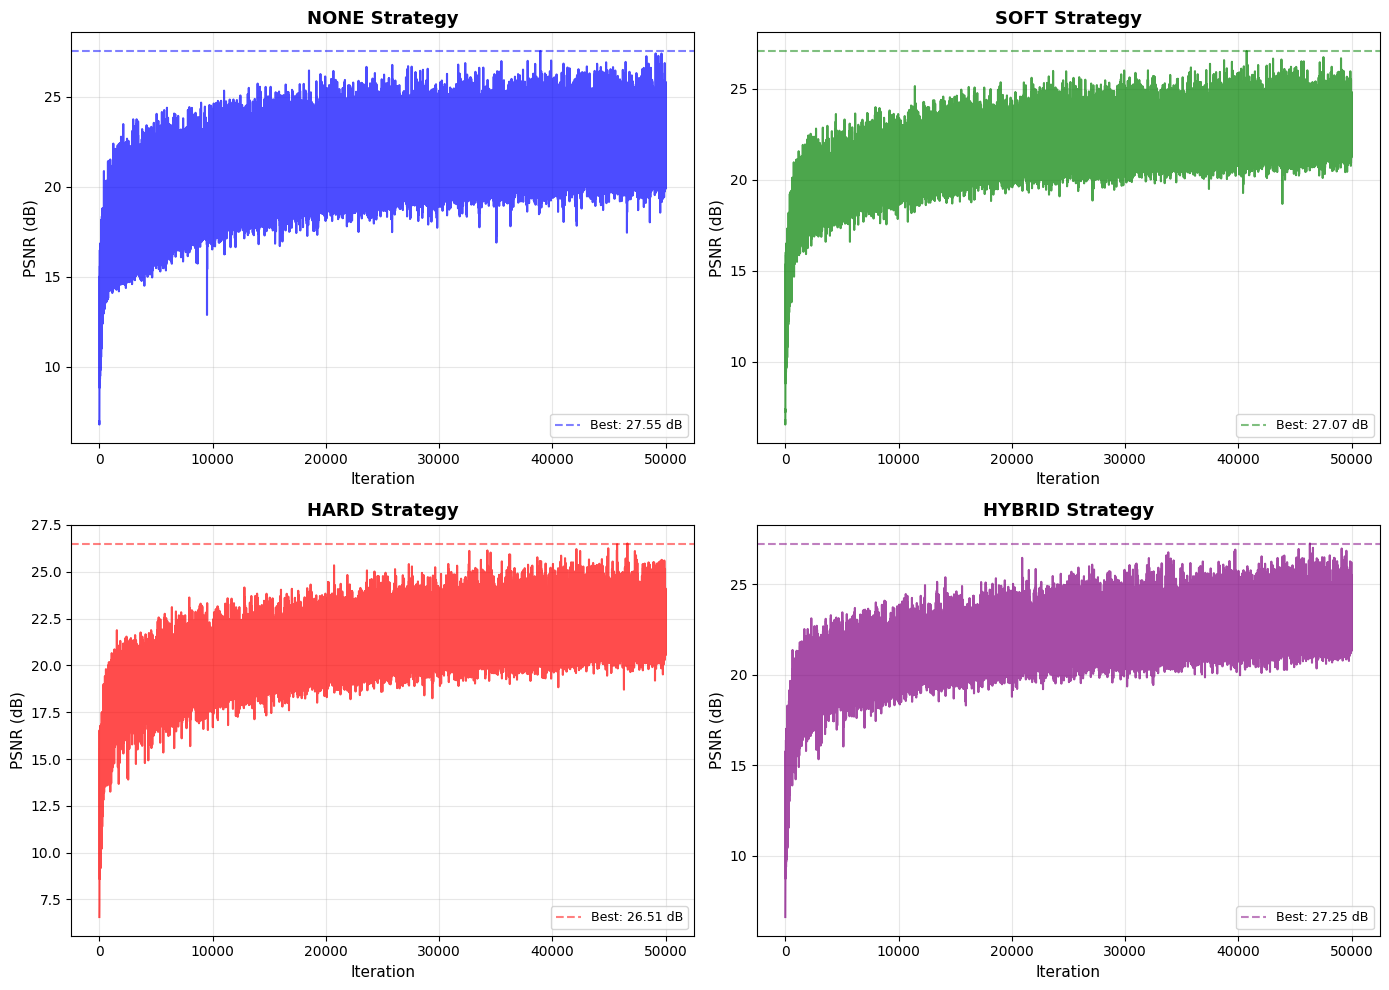

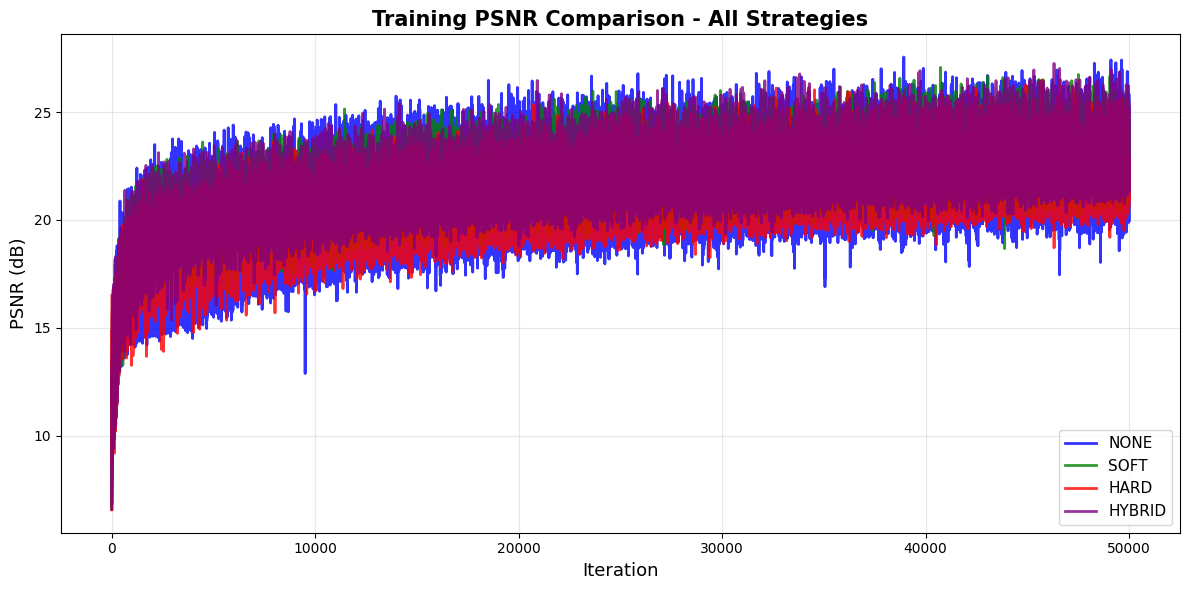

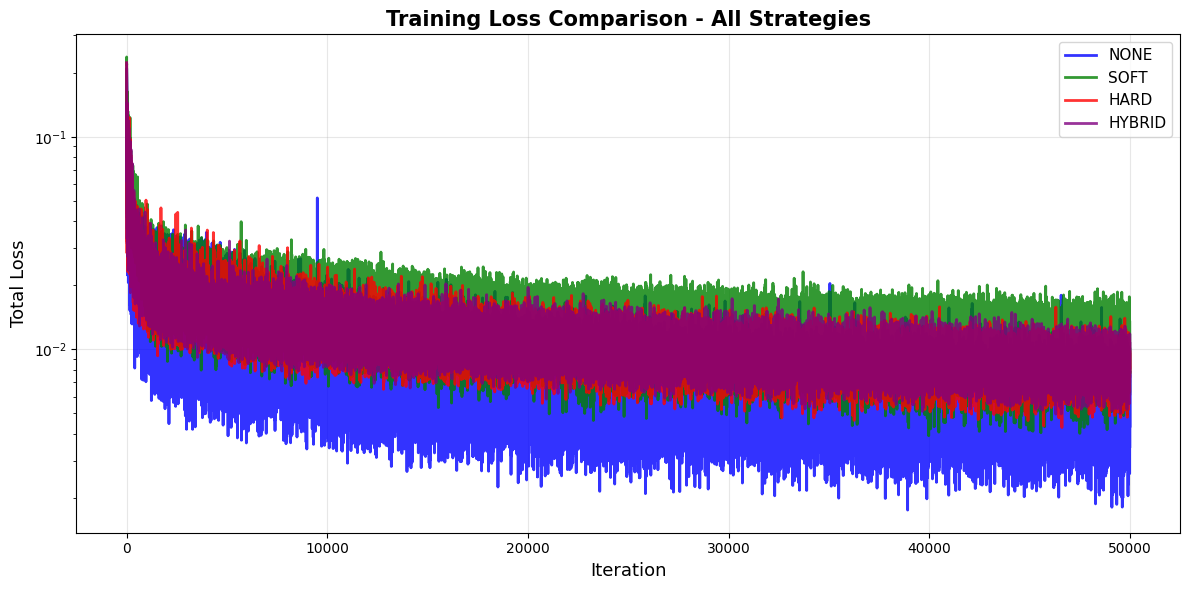

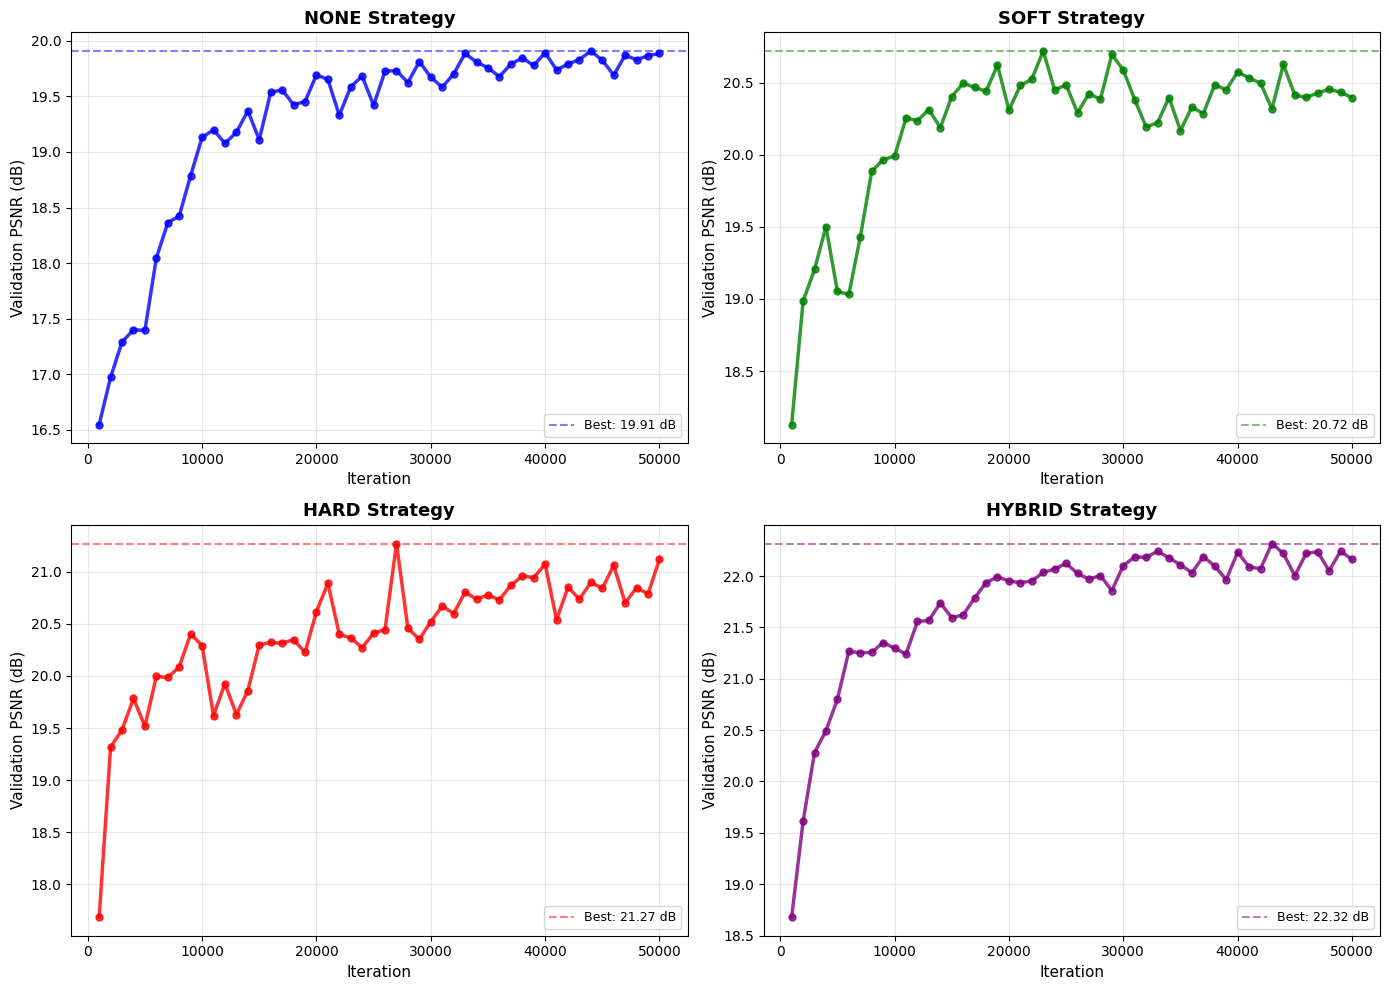

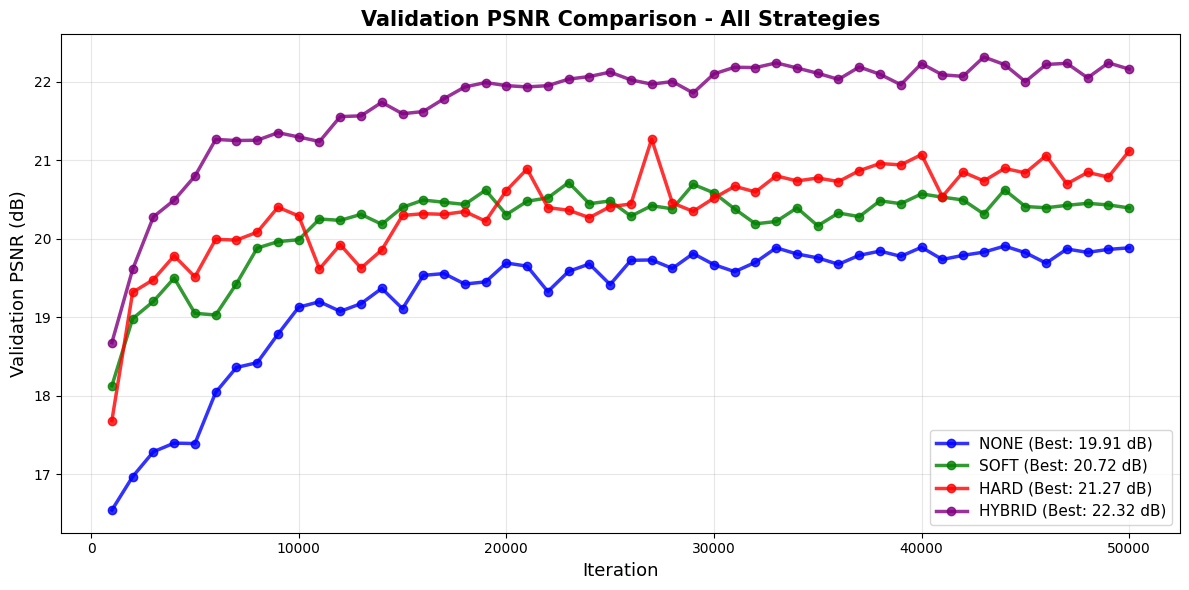


 Training curve plots saved!
 Validation curve plots saved!
 Check if PSNR curves start from ~8-11 dB and increase to 15-20+ dB
   or if they just fluctuate around 20-22 dB (which indicates missing history)


In [ ]:
# PLOT TRAINING CURVES (PSNR progression)
import os
import numpy as np
import matplotlib.pyplot as plt

# Define your 4 strategies
VARIANTS = [
    {"name": "none",   "dir": r"C:\Users\Ayan\Desktop\project\final\none"},
    {"name": "soft",   "dir": r"C:\Users\Ayan\Desktop\project\final\soft"},
    {"name": "hard",   "dir": r"C:\Users\Ayan\Desktop\project\final\hard"},
    {"name": "hybrid", "dir": r"C:\Users\Ayan\Desktop\project\final\hybrid"},
]

colors = {"none": "blue", "soft": "green", "hard": "red", "hybrid": "purple"}

#  Load training histories 
training_curves = {}

for v in VARIANTS:
    name = v["name"]
    psnr_path = os.path.join(v["dir"], "psnr_history.npy")
    loss_path = os.path.join(v["dir"], "loss_history.npy")
    val_psnr_path = os.path.join(v["dir"], "val_psnr_history.npy")
    val_iters_path = os.path.join(v["dir"], "val_iterations.npy")

    if os.path.exists(psnr_path):
        psnr_curve = np.load(psnr_path)
        loss_curve = np.load(loss_path) if os.path.exists(loss_path) else None

        # Load validation PSNR if available
        if os.path.exists(val_psnr_path) and os.path.exists(val_iters_path):
            val_psnr = np.load(val_psnr_path)
            val_iters = np.load(val_iters_path)
        else:
            val_psnr = None
            val_iters = None

        training_curves[name] = {
            "psnr": psnr_curve,
            "loss": loss_curve,
            "val_psnr": val_psnr,
            "val_iters": val_iters
        }

        print(f"[{name}] Training PSNR:")
        print(f"  Initial: {psnr_curve[0]:.2f} dB")
        print(f"  Final: {psnr_curve[-1]:.2f} dB")
        print(f"  Best: {psnr_curve.max():.2f} dB @ iteration {psnr_curve.argmax() + 1}")
        if val_psnr is not None:
            print(f"  Best Validation: {val_psnr.max():.2f} dB @ iteration {val_iters[val_psnr.argmax()]}")
        print(f"  Total improvement: {psnr_curve[-1] - psnr_curve[0]:.2f} dB\n")
    else:
        print(f" Warning: {psnr_path} not found!")

# Plot 1: Individual PSNR curves (2x2 grid) 
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for idx, v in enumerate(VARIANTS):
    name = v["name"]
    if name not in training_curves:
        continue

    psnr_curve = training_curves[name]["psnr"]
    iterations = np.arange(1, len(psnr_curve) + 1)

    ax = axes[idx // 2, idx % 2]
    ax.plot(iterations, psnr_curve, color=colors[name], linewidth=1.5, alpha=0.7)
    ax.axhline(psnr_curve.max(), color=colors[name], linestyle='--', alpha=0.5,
               label=f'Best: {psnr_curve.max():.2f} dB')

    ax.set_xlabel("Iteration", fontsize=11)
    ax.set_ylabel("PSNR (dB)", fontsize=11)
    ax.set_title(f"{name.upper()} Strategy", fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=9)

plt.tight_layout()
plt.savefig(r"C:\Users\Ayan\Desktop\project\final\umer\training_curves_individual.png", dpi=300, bbox_inches='tight')
plt.show()

# Plot 2: Combined comparison (all 4 strategies)
plt.figure(figsize=(12, 6))

for v in VARIANTS:
    name = v["name"]
    if name not in training_curves:
        continue

    psnr_curve = training_curves[name]["psnr"]
    iterations = np.arange(1, len(psnr_curve) + 1)

    plt.plot(iterations, psnr_curve, color=colors[name],
             linewidth=2, alpha=0.8, label=name.upper())

plt.xlabel("Iteration", fontsize=13)
plt.ylabel("PSNR (dB)", fontsize=13)
plt.title("Training PSNR Comparison - All Strategies", fontsize=15, fontweight='bold')
plt.legend(fontsize=11, loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(r"C:\Users\Ayan\Desktop\project\final\umer\training_curves_combined.png", dpi=300, bbox_inches='tight')
plt.show()

# Plot 3: Loss curves 
plt.figure(figsize=(12, 6))

for v in VARIANTS:
    name = v["name"]
    if name not in training_curves or training_curves[name]["loss"] is None:
        continue

    loss_curve = training_curves[name]["loss"]
    iterations = np.arange(1, len(loss_curve) + 1)

    plt.plot(iterations, loss_curve, color=colors[name],
             linewidth=2, alpha=0.8, label=name.upper())

plt.xlabel("Iteration", fontsize=13)
plt.ylabel("Total Loss", fontsize=13)
plt.title("Training Loss Comparison - All Strategies", fontsize=15, fontweight='bold')
plt.legend(fontsize=11, loc='upper right')
plt.grid(True, alpha=0.3)
plt.yscale('log')  # Log scale for better visualization
plt.tight_layout()
plt.savefig(r"C:\Users\Ayan\Desktop\project\final\umer\training_loss_combined.png", dpi=300, bbox_inches='tight')
plt.show()

# Plot 4: Individual Validation PSNR curves (2x2 grid) 
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for idx, v in enumerate(VARIANTS):
    name = v["name"]
    if name not in training_curves:
        continue

    val_psnr = training_curves[name]["val_psnr"]
    val_iters = training_curves[name]["val_iters"]

    ax = axes[idx // 2, idx % 2]

    if val_psnr is not None:
        ax.plot(val_iters, val_psnr, color=colors[name], linewidth=2.5, alpha=0.8,
                marker='o', markersize=5)
        ax.axhline(val_psnr.max(), color=colors[name], linestyle='--', alpha=0.5,
                   label=f'Best: {val_psnr.max():.2f} dB')
    else:
        ax.text(0.5, 0.5, 'No validation data', ha='center', va='center',
                transform=ax.transAxes, fontsize=12)

    ax.set_xlabel("Iteration", fontsize=11)
    ax.set_ylabel("Validation PSNR (dB)", fontsize=11)
    ax.set_title(f"{name.upper()} Strategy", fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=9)

plt.tight_layout()
plt.savefig(r"C:\Users\Ayan\Desktop\project\final\umer\validation_curves_individual.png", dpi=300, bbox_inches='tight')
plt.show()

#  Plot 5: Combined Validation PSNR comparison (all 4 strategies) 
plt.figure(figsize=(12, 6))

for v in VARIANTS:
    name = v["name"]
    if name not in training_curves:
        continue

    val_psnr = training_curves[name]["val_psnr"]
    val_iters = training_curves[name]["val_iters"]

    if val_psnr is not None:
        plt.plot(val_iters, val_psnr, color=colors[name],
                 linewidth=2.5, alpha=0.8, marker='o', markersize=6,
                 label=f"{name.upper()} (Best: {val_psnr.max():.2f} dB)")

plt.xlabel("Iteration", fontsize=13)
plt.ylabel("Validation PSNR (dB)", fontsize=13)
plt.title("Validation PSNR Comparison - All Strategies", fontsize=15, fontweight='bold')
plt.legend(fontsize=11, loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(r"C:\Users\Ayan\Desktop\project\final\umer\validation_curves_combined.png", dpi=300, bbox_inches='tight')
plt.show()

print("\n Training curve plots saved!")
print(" Validation curve plots saved!")
print(" Check if PSNR curves start from ~8-11 dB and increase to 15-20+ dB")
print("   or if they just fluctuate around 20-22 dB (which indicates missing history)")


Verifying checkpoint paths...
✓ [none  ] Found: C:\Users\Ayan\Desktop\project\final\none\model_best_val.pth
✓ [soft  ] Found: C:\Users\Ayan\Desktop\project\final\soft\model_best_val.pth
✓ [hard  ] Found: C:\Users\Ayan\Desktop\project\final\hard\model_best_val.pth
✓ [hybrid] Found: C:\Users\Ayan\Desktop\project\final\hybrid\model_best_val.pth

Evaluation set: 100 images of size 400×400
Focal length: 555.56
Device: cuda

Loading models and computing metrics...

Processing [none] using 'none' renderer...


  Rendering none:   0%|          | 0/100 [00:00<?, ?img/s]

  [none  ] PSNR: 20.21±1.60 dB | SSIM: 0.6578±0.0639
            MSE:  0.010148±0.003358 | MAE:  0.047679±0.012002

Processing [soft] using 'soft' renderer...


  Rendering soft:   0%|          | 0/100 [00:00<?, ?img/s]

  [soft  ] PSNR: 20.71±1.23 dB | SSIM: 0.5225±0.0675
            MSE:  0.008826±0.002431 | MAE:  0.048172±0.008249

Processing [hard] using 'hard' renderer...


  Rendering hard:   0%|          | 0/100 [00:00<?, ?img/s]

  [hard  ] PSNR: 21.17±1.06 dB | SSIM: 0.6855±0.0271
            MSE:  0.007884±0.002100 | MAE:  0.039305±0.006060

Processing [hybrid] using 'hybrid' renderer...


  Rendering hybrid:   0%|          | 0/100 [00:00<?, ?img/s]

  [hybrid] PSNR: 22.36±1.04 dB | SSIM: 0.7782±0.0285
            MSE:  0.005976±0.001450 | MAE:  0.031785±0.005309


✓ Saved metrics summary to: C:\Users\Ayan\Desktop\project\final\comparisons\metrics_summary.csv

Generating per-frame metric plots...


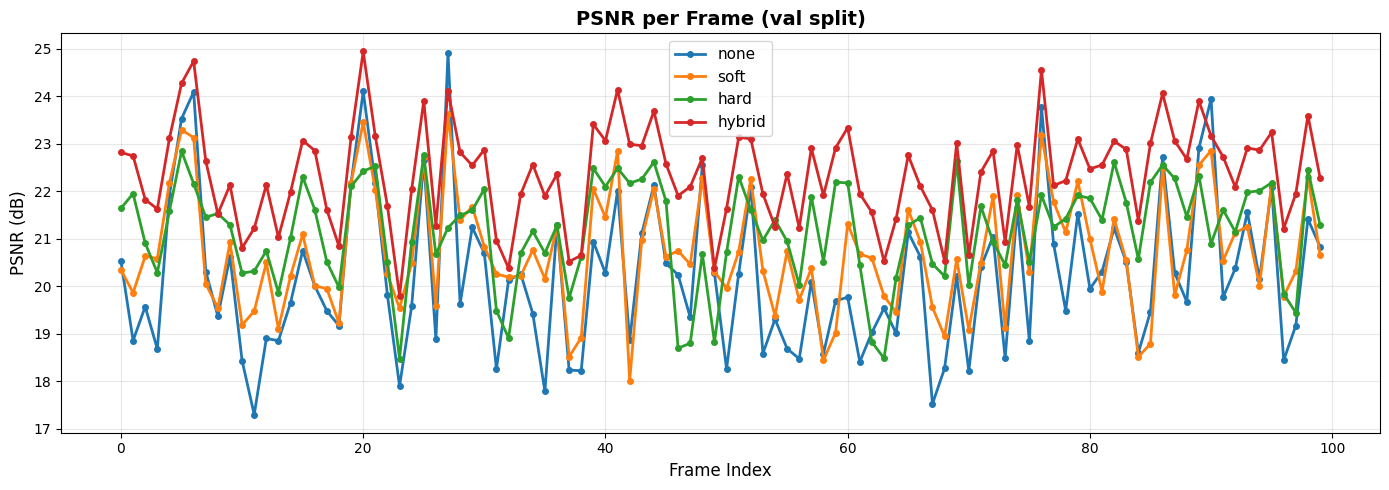

  ✓ Saved: psnr_per_frame.png


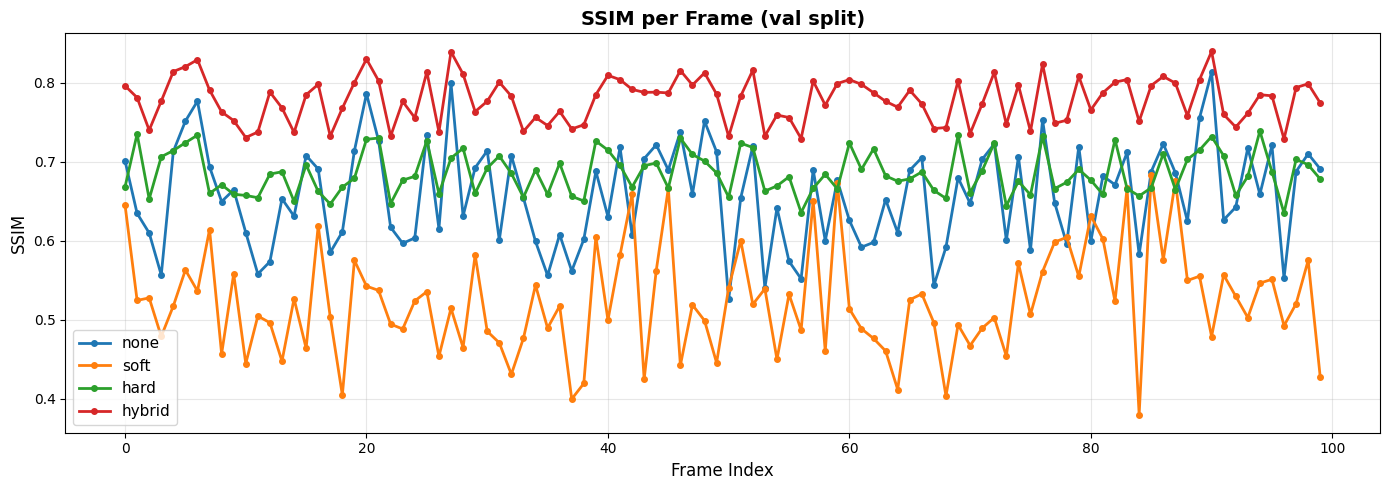

  ✓ Saved: ssim_per_frame.png


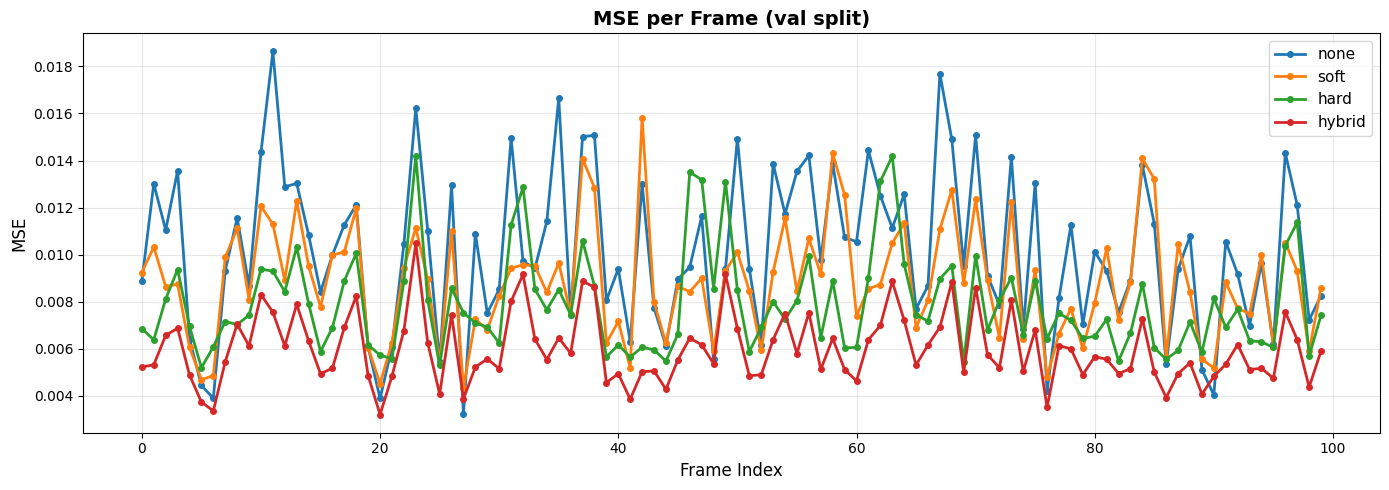

  ✓ Saved: mse_per_frame.png


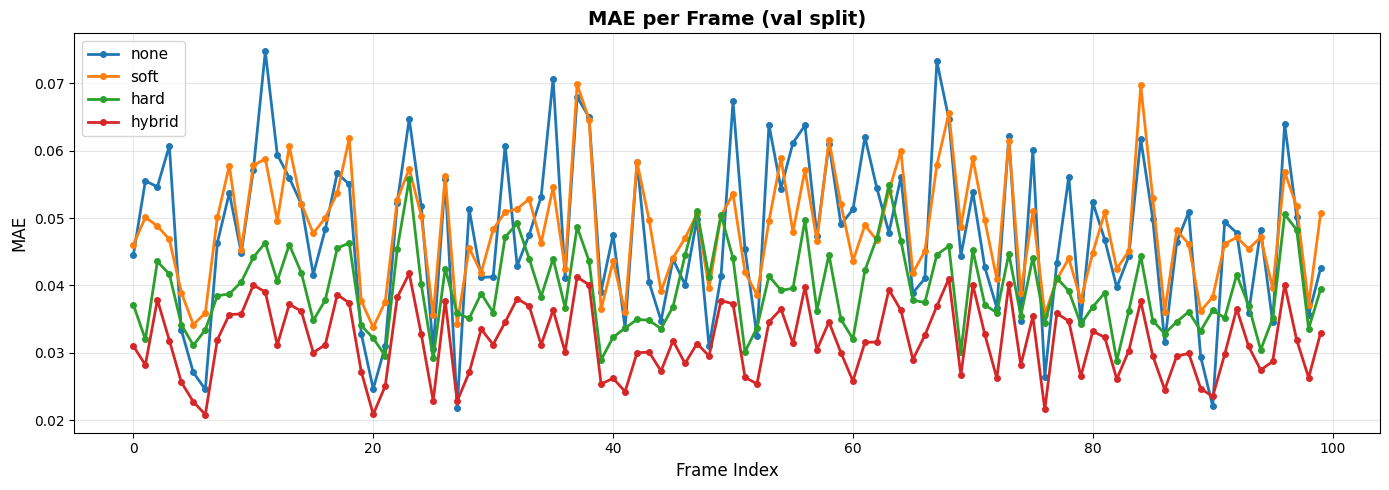

  ✓ Saved: mae_per_frame.png

Generating image comparison visualizations...


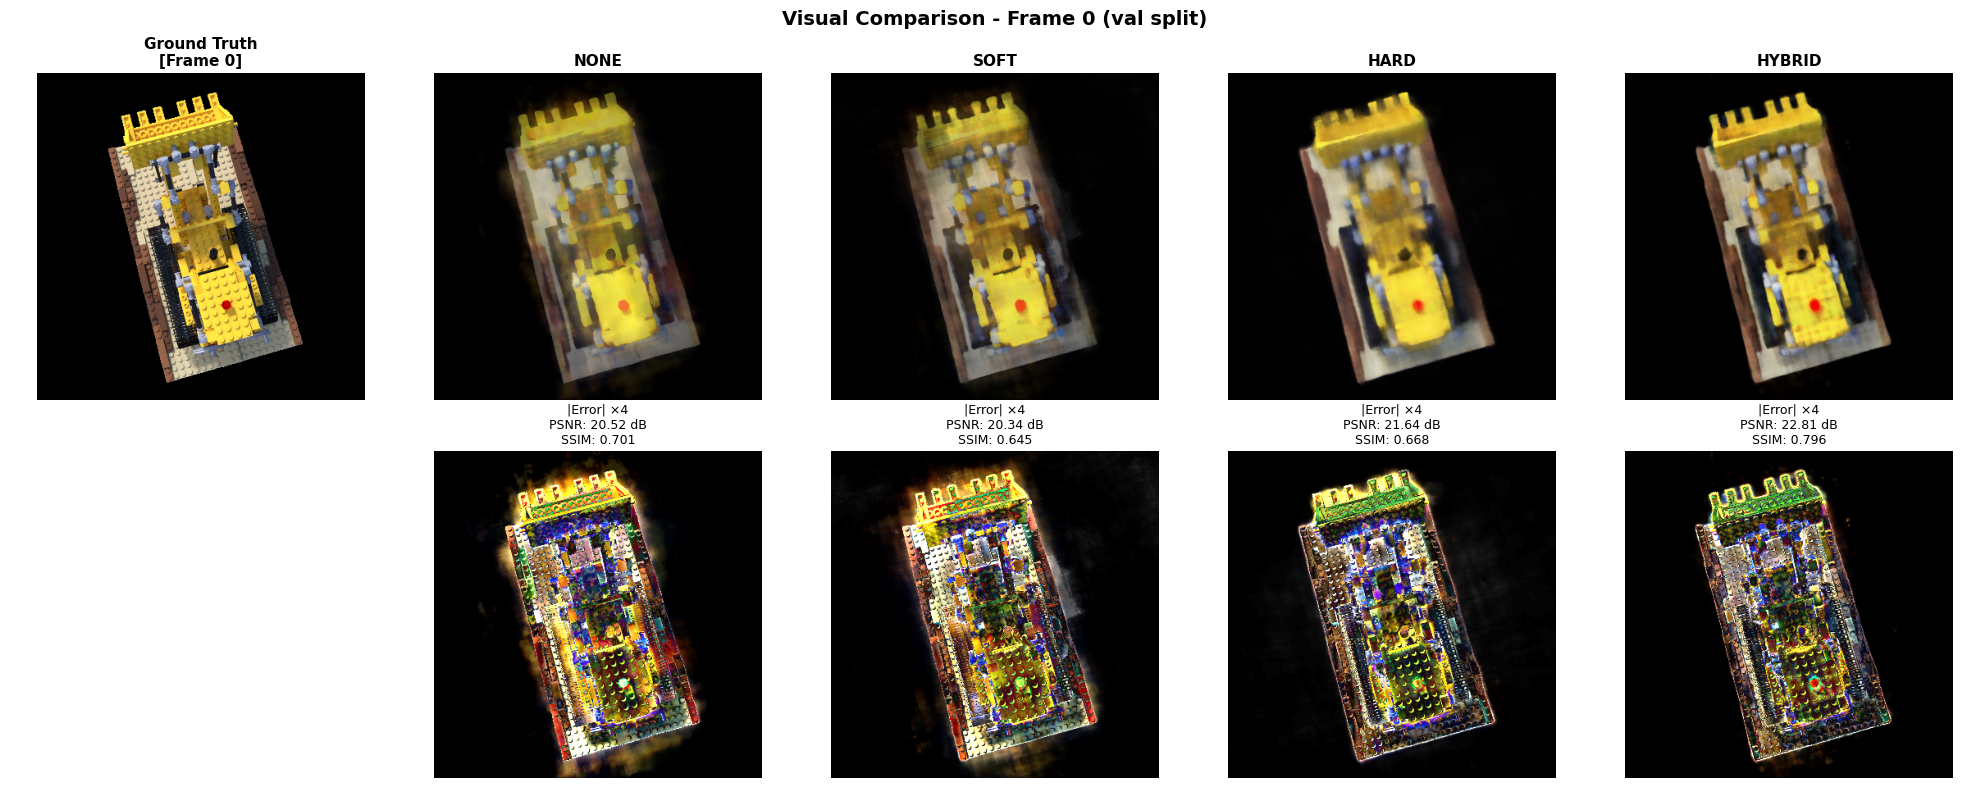

  ✓ Saved: comparison_frame_000.png


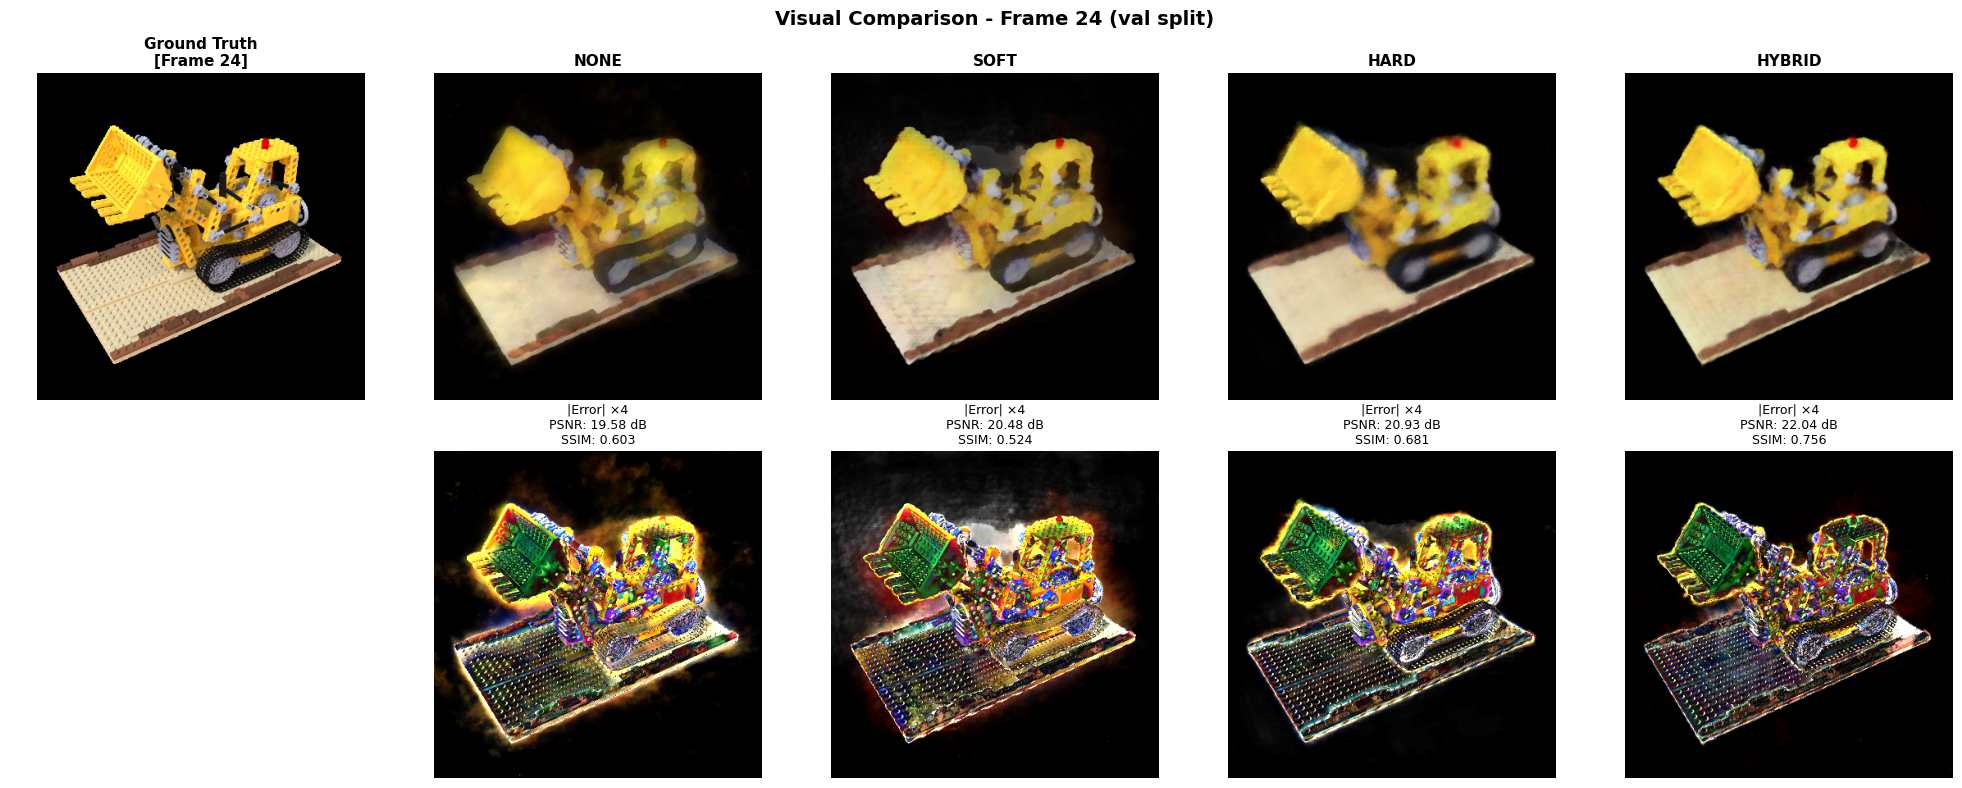

  ✓ Saved: comparison_frame_024.png


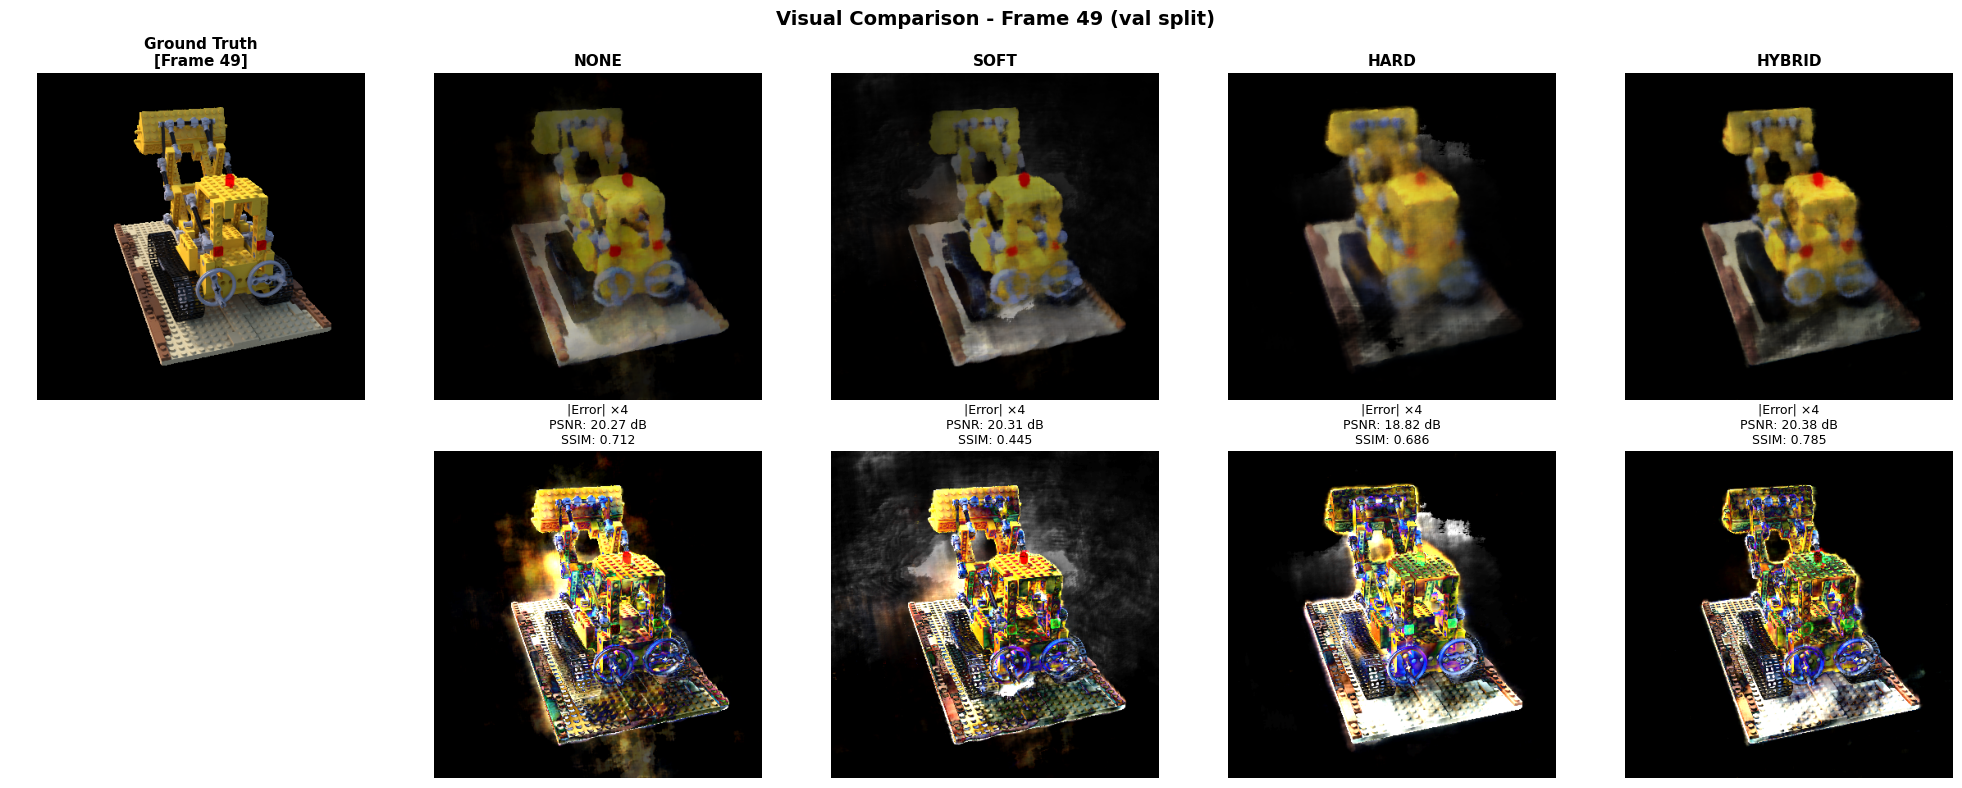

  ✓ Saved: comparison_frame_049.png


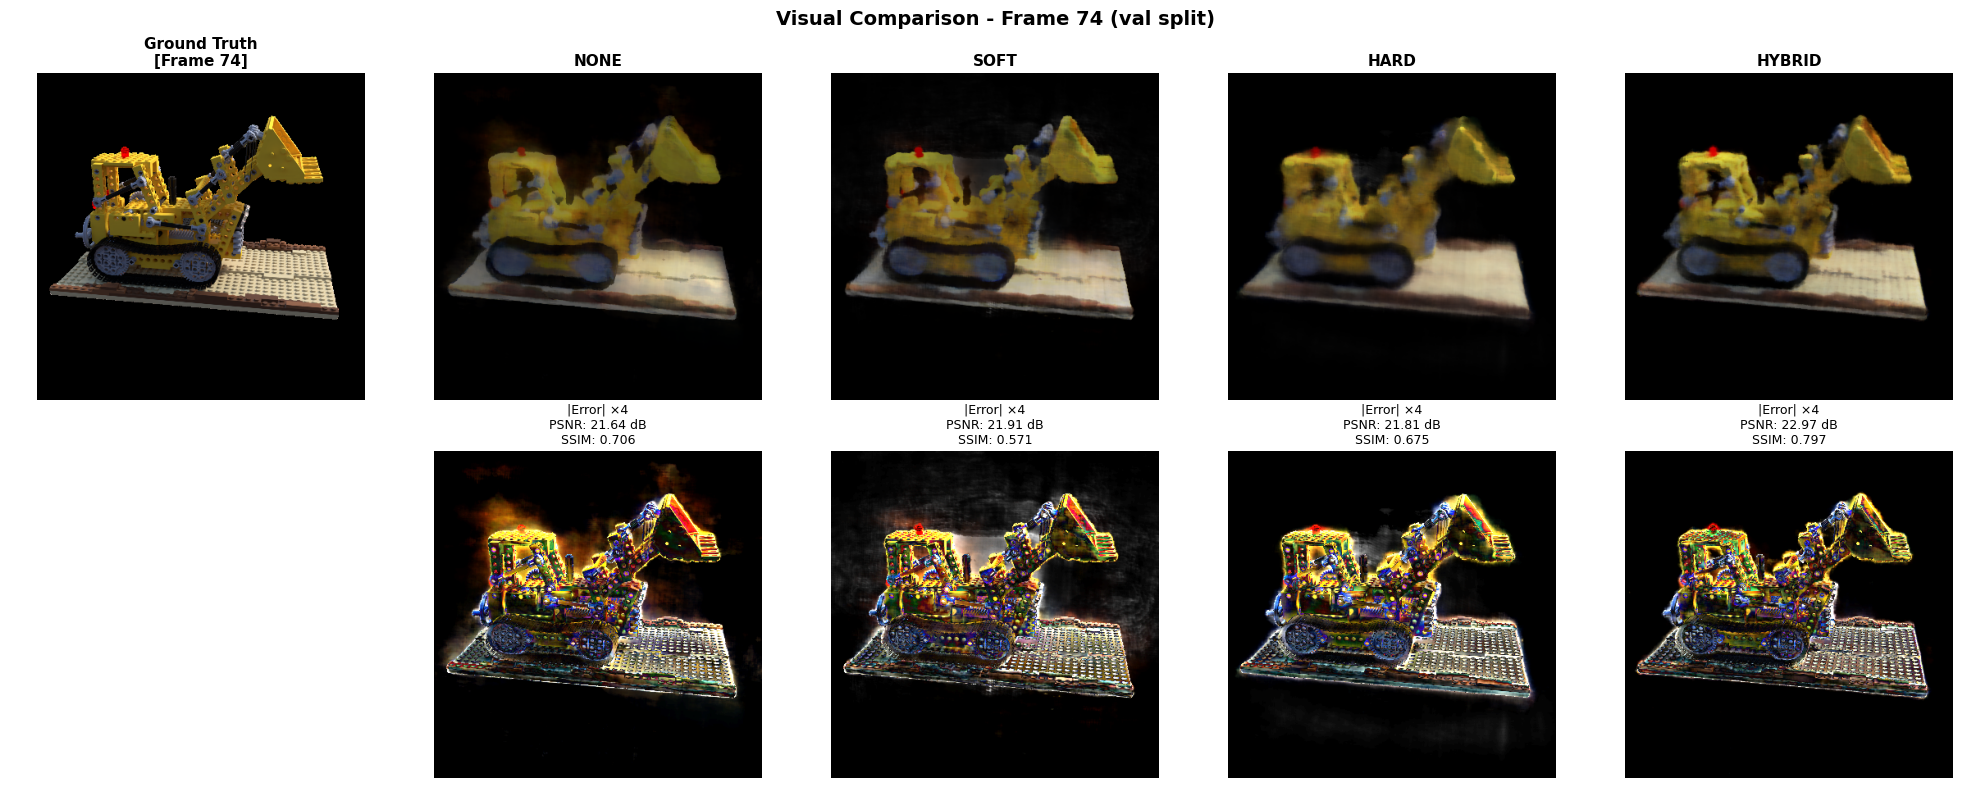

  ✓ Saved: comparison_frame_074.png


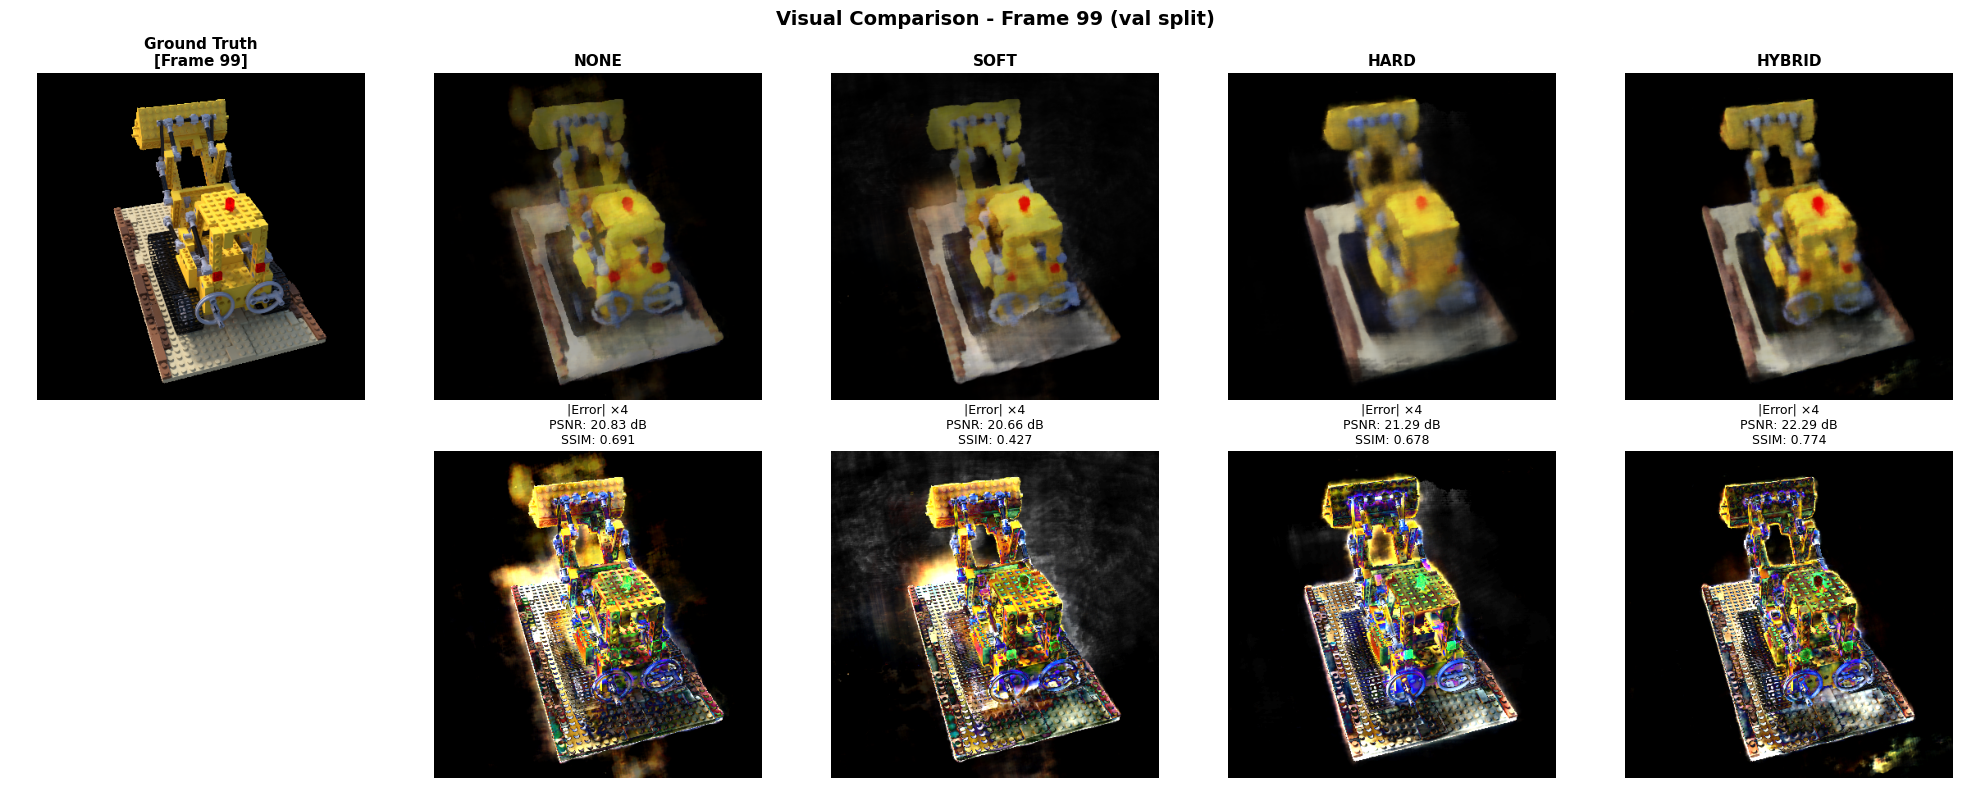

  ✓ Saved: comparison_frame_099.png



In [76]:

import os, numpy as np, matplotlib.pyplot as plt
from tqdm.auto import tqdm
from pathlib import Path
import torch
import torch.nn.functional as F
from skimage.metrics import structural_similarity as ssim


VARIANTS = [
    {
        "name": "none",
        "dir": r"C:\Users\Ayan\Desktop\project\final\none",
        "best_model": "model_best_val.pth",
        "render_type": "none"
    },
    {
        "name": "soft",
        "dir": r"C:\Users\Ayan\Desktop\project\final\soft",
        "best_model": "model_best_val.pth",
        "render_type": "soft"
    },
    {
        "name": "hard",
        "dir": r"C:\Users\Ayan\Desktop\project\final\hard",
        "best_model": "model_best_val.pth",
        "render_type": "hard"
    },
    {
        "name": "hybrid",
        "dir": r"C:\Users\Ayan\Desktop\project\final\hybrid",
        "best_model": "model_best_val.pth",
        "render_type": "hybrid"
    },
]

EVAL_SPLIT = "val"
NEAR, FAR = 2.0, 6.0
NSAMPLES_RENDER = 64
CHUNK = 4096
SAVE_DIR = r"C:\Users\Ayan\Desktop\project\final\comparisons"
os.makedirs(SAVE_DIR, exist_ok=True)

# VERIFY PATHS

print("="*60)
print("Verifying checkpoint paths...")
print("="*60)

for v in VARIANTS:
    model_path = os.path.join(v["dir"], v["best_model"])
    v["pth"] = model_path
    
    if os.path.isfile(model_path):
        print(f"✓ [{v['name']:6s}] Found: {model_path}")
    else:
        fallback_path = os.path.join(v["dir"], "model_best.pth")
        if os.path.isfile(fallback_path):
            v["pth"] = fallback_path
            print(f"⚠ [{v['name']:6s}] Using fallback: {fallback_path}")
        else:
            raise FileNotFoundError(f"Missing: {model_path}")

print("="*60 + "\n")

# LOAD VALIDATION DATA

imgs_eval, poses_eval = imgs_val, poses_val
H_eval, W_eval, focal_eval = H, W, focal

images_eval = torch.from_numpy(imgs_eval).to(device).float()
poses_eval_t = torch.from_numpy(poses_eval).to(device).float()
N_eval = images_eval.shape[0]

print(f"Evaluation set: {N_eval} images of size {H_eval}×{W_eval}")
print(f"Focal length: {focal_eval:.2f}")
print(f"Device: {device}\n")


# NONE STRATEGY: render_rays()
@torch.no_grad()
def render_rays_none(model, rays_o, rays_d, near=2.0, far=6.0, n_samples=64, perturb=False, white_bkgd=True):
    """
    EXACT copy from your NONE training code
    Includes the double softplus bug from training
    """
    # Stratified samples in [near, far]
    t_vals = torch.linspace(0., 1., steps=n_samples, device=rays_o.device)
    z_vals = near * (1. - t_vals) + far * t_vals
    z_vals = z_vals[None, :].repeat(rays_o.shape[0], 1)
    
    if perturb:
        mids = 0.5 * (z_vals[:, :-1] + z_vals[:, 1:])
        upper = torch.cat([mids, z_vals[:, -1:]], -1)
        lower = torch.cat([z_vals[:, :1], mids], -1)
        z_vals = lower + (upper - lower) * torch.rand_like(z_vals)

    # Points
    pts = rays_o[:, None, :] + rays_d[:, None, :] * z_vals[..., None] 

    # Encodings
    dirs = F.normalize(rays_d, dim=-1)
    dirs_enc = pe_dir(dirs)    
    pts_enc = pe_xyz(pts)        


    N, S = pts_enc.shape[:2]
    x = pts_enc.reshape(N*S, -1)
    d = dirs_enc[:, None, :].expand(N, S, -1).reshape(N*S, -1)

    rgb, sigma = model(x, d)     
    rgb = rgb.view(N, S, 3)
    sigma = F.softplus(sigma.view(N, S))  

    # Volume render
    deltas = z_vals[:, 1:] - z_vals[:, :-1]
    deltas = torch.cat([deltas, 1e10 * torch.ones_like(deltas[:, :1])], -1)
    alpha = 1. - torch.exp(-sigma * deltas)
    T = torch.cumprod(torch.cat([torch.ones((N,1), device=alpha.device), 1. - alpha + 1e-10], -1), -1)[:, :-1]
    weights = alpha * T

    rgb_map = (weights[..., None] * rgb).sum(dim=1)
    depth_map = (weights * z_vals).sum(dim=1)

    if white_bkgd:
        acc_map = weights.sum(dim=1, keepdim=True)
        rgb_map = rgb_map + (1. - acc_map)

    return rgb_map.clamp(0, 1), depth_map


# SOFT STRATEGY: render_rays()
@torch.no_grad()
def render_rays_soft(nerf, rays_o, rays_d, near, far, N_samples, white_bg=True):
  
    # Stratified sampling
    z_vals = torch.linspace(near, far, N_samples, device=rays_o.device)
    z_vals = z_vals.unsqueeze(0) 

    pts = rays_o[..., None, :] + rays_d[..., None, :] * z_vals[..., :, None]  
    pts_flat = pts.reshape(-1, 3)
    dirs_flat = rays_d.unsqueeze(1).expand_as(pts).reshape(-1, 3)

    # Encode
    pts_enc = pe_xyz(pts_flat)
    dirs_enc = pe_dir(dirs_flat)

    # MLP forward
    rgb, sigma = nerf(pts_enc, dirs_enc)
    rgb = rgb.view(*pts.shape[:-1], 3)  
    sigma = sigma.view(*pts.shape[:-1]) 

    # Volume rendering
    deltas = z_vals[..., 1:] - z_vals[..., :-1]
    deltas = torch.cat([deltas, 1e-3 * torch.ones_like(deltas[..., :1])], dim=-1)
    alpha = 1.0 - torch.exp(-sigma * deltas)
    trans = torch.cumprod(torch.cat([torch.ones_like(alpha[..., :1]), 1.-alpha + 1e-10], dim=-1), dim=-1)[..., :-1]
    weights = alpha * trans

    rgb_map = (weights[..., None] * rgb).sum(dim=-2)
    if white_bg:
        rgb_map = rgb_map + (1 - weights.sum(dim=-1, keepdim=True))

    depth_soft = (weights * z_vals).sum(dim=-1)
    return rgb_map.clamp(0, 1), depth_soft


# HARD STRATEGY: render_rays()
@torch.no_grad()
def render_rays_hard(model, rays_o, rays_d, near, far, N_samples,
                     depth_gt=None, depth_mask=None, eps=0.5,
                     white_bg=True, return_extras=False):
    """
    EXACT copy from your HARD training code
    For evaluation: no depth_gt, so falls back to uniform sampling
    """
    N_rays = rays_o.shape[0]

    z_vals = torch.linspace(near, far, N_samples, device=rays_o.device)
    z_vals = z_vals[None, :].expand(N_rays, -1)  

    # Points along rays
    pts = rays_o[:, None, :] + rays_d[:, None, :] * z_vals[..., None]  

    # Encode dirs and pts
    dirs = F.normalize(rays_d, dim=-1)
    dirs_enc = pe_dir(dirs) 
    pts_enc = pe_xyz(pts)   

    N, S = pts_enc.shape[:2]
    x = pts_enc.reshape(N * S, -1)
    d = dirs_enc[:, None, :].expand(N, S, -1).reshape(N * S, -1)

    rgb, sigma = model(x, d) 
    rgb = rgb.view(N, S, 3)
    sigma = sigma.view(N, S)

    # Volume rendering
    deltas = z_vals[:, 1:] - z_vals[:, :-1]
    deltas = torch.cat([deltas, 1e-3 * torch.ones_like(deltas[:, :1])], dim=-1)

    alpha = 1.0 - torch.exp(-sigma * deltas)
    trans = torch.cumprod(
        torch.cat([torch.ones_like(alpha[:, :1]), 1. - alpha + 1e-10], dim=-1),
        dim=-1
    )[:, :-1]

    weights = alpha * trans  

    rgb_map = (weights[..., None] * rgb).sum(dim=1)  
    if white_bg:
        rgb_map = rgb_map + (1 - weights.sum(dim=1, keepdim=True))

    depth_pred = (weights * z_vals).sum(dim=1) 

    if return_extras:
        return rgb_map.clamp(0, 1), depth_pred, weights, z_vals, sigma
    else:
        return rgb_map.clamp(0, 1), depth_pred


# HYBRID STRATEGY: render_rays()
@torch.no_grad()
def render_rays_hybrid(model, rays_o, rays_d, near, far, N_samples,
                       depth_gt=None, depth_mask=None, eps=0.3,
                       white_bg=True, return_extras=False):

    N_rays = rays_o.shape[0]

    # Fallback to uniform sampling (no depth at test time)
    z_vals = torch.linspace(near, far, N_samples, device=rays_o.device)
    z_vals = z_vals[None, :].expand(N_rays, -1)

    # Points along rays
    pts = rays_o[:, None, :] + rays_d[:, None, :] * z_vals[..., None]

    # Encode
    dirs = F.normalize(rays_d, dim=-1)
    dirs_enc = pe_dir(dirs)
    pts_enc = pe_xyz(pts)   

    N, S = pts_enc.shape[:2]
    x = pts_enc.reshape(N * S, -1)
    d = dirs_enc[:, None, :].expand(N, S, -1).reshape(N * S, -1)

    rgb, sigma = model(x, d)
    rgb = rgb.view(N, S, 3)
    sigma = sigma.view(N, S)

    # Volume rendering
    deltas = z_vals[:, 1:] - z_vals[:, :-1]
    deltas = torch.cat([deltas, 1e10 * torch.ones_like(deltas[:, :1])], -1)
    alpha = 1. - torch.exp(-sigma * deltas)
    T = torch.cumprod(torch.cat([torch.ones((N,1), device=alpha.device), 1. - alpha + 1e-10], -1), -1)[:, :-1]
    weights = alpha * T

    rgb_map = (weights[..., None] * rgb).sum(dim=1)
    depth_map = (weights * z_vals).sum(dim=1)

    if white_bg:
        acc_map = weights.sum(dim=1, keepdim=True)
        rgb_map = rgb_map + (1. - acc_map)

    if return_extras:
        return rgb_map.clamp(0, 1), depth_map, weights, z_vals, sigma
    else:
        return rgb_map.clamp(0, 1), depth_map



# FULL IMAGE RENDERING

@torch.no_grad()
def render_full_image(model, c2w, H, W, focal, render_type="none", chunk=CHUNK):
    """Render complete image with variant-specific renderer"""
    model.eval()
    rays_o, rays_d = get_rays(H, W, focal, c2w)
    rays_o = rays_o.view(-1, 3)
    rays_d = rays_d.view(-1, 3)

    outs = []
    for i in range(0, rays_o.shape[0], chunk):
        if render_type == "soft":
            rgb, _ = render_rays_soft(
                model, rays_o[i:i+chunk], rays_d[i:i+chunk],
                near=NEAR, far=FAR, N_samples=NSAMPLES_RENDER, white_bg=True
            )
        elif render_type == "hard":
            rgb, _ = render_rays_hard(
                model, rays_o[i:i+chunk], rays_d[i:i+chunk],
                near=NEAR, far=FAR, N_samples=NSAMPLES_RENDER,
                depth_gt=None, depth_mask=None, white_bg=True
            )
        elif render_type == "hybrid":
            rgb, _ = render_rays_hybrid(
                model, rays_o[i:i+chunk], rays_d[i:i+chunk],
                near=NEAR, far=FAR, N_samples=NSAMPLES_RENDER,
                depth_gt=None, depth_mask=None, white_bg=True
            )
        else:  # "none"
            rgb, _ = render_rays_none(
                model, rays_o[i:i+chunk], rays_d[i:i+chunk],
                near=NEAR, far=FAR, n_samples=NSAMPLES_RENDER,
                perturb=False, white_bkgd=True
            )
        outs.append(rgb)
    
    img = torch.cat(outs, 0).view(H, W, 3)
    return img



# METRICS COMPUTATION

def compute_metrics(pred_np, gt_np):
    """Compute PSNR, SSIM, MSE, MAE"""
    pred_np = np.clip(pred_np, 0.0, 1.0).astype(np.float32)
    gt_np = np.clip(gt_np, 0.0, 1.0).astype(np.float32)

    diff = pred_np - gt_np
    mse_val = float(np.mean(diff**2))
    mae_val = float(np.mean(np.abs(diff)))
    
    psnr_val = float(10.0 * np.log10(1.0 / (mse_val + 1e-12)))
    ssim_val = float(ssim(gt_np, pred_np, channel_axis=-1, data_range=1.0))
    
    return mse_val, mae_val, psnr_val, ssim_val



# MAIN EVALUATION LOOP

print("="*60)
print("Loading models and computing metrics...")
print("="*60 + "\n")

all_results = {}
all_renders = {}

for v in VARIANTS:
    name, pth = v["name"], v["pth"]
    render_type = v["render_type"]
    
    print(f"Processing [{name}] using '{render_type}' renderer...")
    
    m = NeRF().to(device)
    state = torch.load(pth, map_location=device, weights_only=True)
    m.load_state_dict(state)
    m.eval()

    mse_list, mae_list, psnr_list, ssim_list = [], [], [], []
    renders_uint8 = []

    # Evaluate on all validation images
    for i in tqdm(range(N_eval), desc=f"  Rendering {name}", unit="img", leave=False):
        pred = render_full_image(
            m, poses_eval_t[i], H_eval, W_eval, focal_eval,
            render_type=render_type
        ).detach().cpu().numpy()
        
        gt = images_eval[i].detach().cpu().numpy()

        mse_v, mae_v, psnr_v, ssim_v = compute_metrics(pred, gt)
        mse_list.append(mse_v)
        mae_list.append(mae_v)
        psnr_list.append(psnr_v)
        ssim_list.append(ssim_v)
        renders_uint8.append((pred * 255.0).astype(np.uint8))

    all_results[name] = {
        "mse": np.array(mse_list),
        "mae": np.array(mae_list),
        "psnr": np.array(psnr_list),
        "ssim": np.array(ssim_list),
    }
    all_renders[name] = renders_uint8

    print(f"  [{name:6s}] PSNR: {all_results[name]['psnr'].mean():.2f}±{all_results[name]['psnr'].std():.2f} dB | "
          f"SSIM: {all_results[name]['ssim'].mean():.4f}±{all_results[name]['ssim'].std():.4f}")
    print(f"            MSE:  {all_results[name]['mse'].mean():.6f}±{all_results[name]['mse'].std():.6f} | "
          f"MAE:  {all_results[name]['mae'].mean():.6f}±{all_results[name]['mae'].std():.6f}\n")

print("="*60 + "\n")


# SAVE METRICS TO CSV

import pandas as pd

summary_data = []
for v in VARIANTS:
    name = v["name"]
    summary_data.append({
        "Variant": name,
        "PSNR_mean": all_results[name]['psnr'].mean(),
        "PSNR_std": all_results[name]['psnr'].std(),
        "SSIM_mean": all_results[name]['ssim'].mean(),
        "SSIM_std": all_results[name]['ssim'].std(),
        "MSE_mean": all_results[name]['mse'].mean(),
        "MSE_std": all_results[name]['mse'].std(),
        "MAE_mean": all_results[name]['mae'].mean(),
        "MAE_std": all_results[name]['mae'].std(),
    })

df_summary = pd.DataFrame(summary_data)
df_summary.to_csv(os.path.join(SAVE_DIR, "metrics_summary.csv"), index=False)
print(f"✓ Saved metrics summary to: {os.path.join(SAVE_DIR, 'metrics_summary.csv')}\n")


# PLOT PER-FRAME CURVES

print("Generating per-frame metric plots...")

def plot_metric(metric, ylabel, filename):
    plt.figure(figsize=(14, 5))
    for v in VARIANTS:
        name = v["name"]
        plt.plot(all_results[name][metric], label=name, marker='o', markersize=4, linewidth=2)
    
    plt.title(f"{metric.upper()} per Frame ({EVAL_SPLIT} split)", fontsize=14, fontweight='bold')
    plt.xlabel("Frame Index", fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.legend(fontsize=11, loc='best')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(SAVE_DIR, filename), dpi=150, bbox_inches='tight')
    plt.show()
    print(f"  ✓ Saved: {filename}")

plot_metric("psnr", "PSNR (dB)", "psnr_per_frame.png")
plot_metric("ssim", "SSIM", "ssim_per_frame.png")
plot_metric("mse", "MSE", "mse_per_frame.png")
plot_metric("mae", "MAE", "mae_per_frame.png")
print()




# IMAGE COMPARISONS

print("Generating image comparison visualizations...")

show_ids = np.linspace(0, N_eval - 1, num=min(5, N_eval), dtype=int)

for idx in show_ids:
    gt = (images_eval[idx].detach().cpu().numpy() * 255.0).astype(np.uint8)

    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    
    axes[0, 0].imshow(gt)
    axes[0, 0].set_title(f"Ground Truth\n[Frame {idx}]", fontsize=11, fontweight='bold')
    axes[0, 0].axis("off")
    axes[1, 0].axis("off")

    for j, v in enumerate(VARIANTS):
        name = v["name"]
        pr = all_renders[name][idx]

        axes[0, j+1].imshow(pr)
        axes[0, j+1].set_title(f"{name.upper()}", fontsize=11, fontweight='bold')
        axes[0, j+1].axis("off")

        err = np.clip(np.abs(pr.astype(np.float32) - gt.astype(np.float32)) * 4.0, 0, 255).astype(np.uint8)
        axes[1, j+1].imshow(err)
        axes[1, j+1].set_title(
            f"|Error| ×4\n"
            f"PSNR: {all_results[name]['psnr'][idx]:.2f} dB\n"
            f"SSIM: {all_results[name]['ssim'][idx]:.3f}",
            fontsize=9
        )
        axes[1, j+1].axis("off")

    plt.suptitle(f"Visual Comparison - Frame {idx} ({EVAL_SPLIT} split)", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(SAVE_DIR, f"comparison_frame_{idx:03d}.png"), dpi=150, bbox_inches='tight')
    plt.show()
    print(f"  ✓ Saved: comparison_frame_{idx:03d}.png")

print()


